In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from betavae import BVAE
from supervised_bvae import SupervisedBVAE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
z_dim = 16
beta = 1

num_epochs = 50
batch_size = 64
gradient_accumulation_steps = 1
lr = 1e-3

updates_per_epoch = 1

In [3]:
rand_state = 420

torch.manual_seed(rand_state)
np.random.seed(rand_state)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
shapes_meta = pd.read_csv('shapes.csv')
shapes_meta.head()

,shape,color,r,g,b,wscale,hscale,rotation,skew,xcenter,ycenter,hatch,shadow
0,hexagon,mango,1.000000,0.650980,0.168627,1.000000,1.000000,0.000000,-27.178834,29.632195,-21.188916,NaN,False
1,ellipse,burnt orange,0.752941,0.305882,0.003922,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,False
2,pentagon,turquoise blue,0.023529,0.694118,0.768627,1.000000,1.000000,31.973350,-15.998241,0.000000,0.000000,NaN,False
3,hexagon,mud green,0.376471,0.400000,0.007843,1.000000,1.000000,0.000000,0.000000,-32.740097,0.000000,NaN,False
4,hexagon,pale brown,0.694118,0.568627,0.431373,0.810421,0.810421,122.359745,-22.210472,0.000000,-6.132901,.,False


In [6]:
resize = transforms.Resize(64)
shapes = resize(torch.load('shapes.pt').permute(0, 3, 1, 2) / 255)
del resize
shapes.shape

torch.Size([20000, 3, 64, 64])

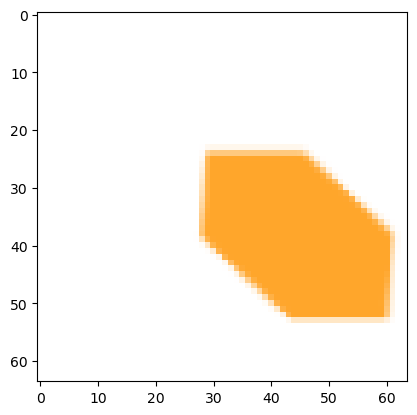

In [7]:
plt.imshow(shapes[0].permute(1, 2, 0).cpu())

In [8]:
train, valid = train_test_split(shapes, test_size=0.1, random_state=rand_state)
train_meta, valid_meta = train_test_split(shapes_meta, test_size=0.1, random_state=rand_state)
del shapes

In [12]:
train_meta, valid_meta = train_test_split(shapes_meta, test_size=0.1, random_state=rand_state)
train_meta = torch.tensor(train_meta.iloc[:,2:5].values).float()
valid_meta = torch.tensor(valid_meta.iloc[:,2:5].values).float()

In [15]:
from torch.utils.data import Dataset

bce_loss = nn.BCELoss(reduction='sum')
mse_loss = nn.MSELoss(reduction='sum')
def vae_loss(x, mu, var, recon, beta):
    recon_loss = bce_loss(recon, x)
    kl = -torch.sum(1 + var - torch.pow(mu, 2) - torch.exp(var)) / 2
    return (recon_loss + beta * kl) / x.size(0)

def supervised_vae_loss(x, yhat, supervision, mu, var, recon, beta):
    a = mse_loss(yhat, supervision)
    print(a)
    return vae_loss(x, mu, var, recon, beta) + a

class DatasetWrapper(Dataset):
    def __init__(self, imgs, latent_supervision):
        self.imgs = imgs
        self.latent_supervision = latent_supervision
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        return self.imgs[idx], self.latent_supervision[idx]

Epoch 1:   1%|█▎                                                                                                                                                                                        | 2/282 [00:00<00:33,  8.41it/s]

tensor(157.8036, grad_fn=<MseLossBackward0>)
tensor(122.5088, grad_fn=<MseLossBackward0>)


Epoch 1:   1%|██▋                                                                                                                                                                                       | 4/282 [00:00<00:30,  9.00it/s]

tensor(131.7301, grad_fn=<MseLossBackward0>)
tensor(117.2190, grad_fn=<MseLossBackward0>)


Epoch 1:   2%|███▉                                                                                                                                                                                      | 6/282 [00:00<00:32,  8.62it/s]

tensor(85.5052, grad_fn=<MseLossBackward0>)
tensor(76.6252, grad_fn=<MseLossBackward0>)


Epoch 1:   2%|████▌                                                                                                                                                                                     | 7/282 [00:00<00:32,  8.36it/s]

tensor(53.2914, grad_fn=<MseLossBackward0>)
tensor(65.7435, grad_fn=<MseLossBackward0>)


Epoch 1:   4%|██████▌                                                                                                                                                                                  | 10/282 [00:01<00:33,  8.01it/s]

tensor(48.5957, grad_fn=<MseLossBackward0>)
tensor(47.2249, grad_fn=<MseLossBackward0>)


Epoch 1:   4%|███████▏                                                                                                                                                                                 | 11/282 [00:01<00:33,  8.03it/s]

tensor(33.9306, grad_fn=<MseLossBackward0>)
tensor(33.7884, grad_fn=<MseLossBackward0>)


Epoch 1:   5%|████████▌                                                                                                                                                                                | 13/282 [00:01<00:36,  7.47it/s]

tensor(45.2079, grad_fn=<MseLossBackward0>)
tensor(43.5364, grad_fn=<MseLossBackward0>)


Epoch 1:   6%|██████████▍                                                                                                                                                                              | 16/282 [00:01<00:34,  7.74it/s]

tensor(37.9176, grad_fn=<MseLossBackward0>)
tensor(35.8233, grad_fn=<MseLossBackward0>)


Epoch 1:   6%|███████████▏                                                                                                                                                                             | 17/282 [00:02<00:32,  8.18it/s]

tensor(28.9206, grad_fn=<MseLossBackward0>)
tensor(25.8981, grad_fn=<MseLossBackward0>)
tensor(30.5740, grad_fn=<MseLossBackward0>)


Epoch 1:   7%|█████████████▊                                                                                                                                                                           | 21/282 [00:02<00:28,  9.15it/s]

tensor(31.0016, grad_fn=<MseLossBackward0>)
tensor(28.0932, grad_fn=<MseLossBackward0>)


Epoch 1:   8%|███████████████                                                                                                                                                                          | 23/282 [00:02<00:27,  9.37it/s]

tensor(28.4962, grad_fn=<MseLossBackward0>)
tensor(24.3974, grad_fn=<MseLossBackward0>)


Epoch 1:   9%|███████████████▋                                                                                                                                                                         | 24/282 [00:02<00:27,  9.44it/s]

tensor(22.2886, grad_fn=<MseLossBackward0>)
tensor(25.6321, grad_fn=<MseLossBackward0>)
tensor(22.5696, grad_fn=<MseLossBackward0>)


Epoch 1:  10%|██████████████████▎                                                                                                                                                                      | 28/282 [00:03<00:25, 10.09it/s]

tensor(20.7018, grad_fn=<MseLossBackward0>)
tensor(22.3537, grad_fn=<MseLossBackward0>)
tensor(16.6109, grad_fn=<MseLossBackward0>)


Epoch 1:  11%|███████████████████▋                                                                                                                                                                     | 30/282 [00:03<00:24, 10.24it/s]

tensor(18.6537, grad_fn=<MseLossBackward0>)
tensor(19.1416, grad_fn=<MseLossBackward0>)
tensor(20.3117, grad_fn=<MseLossBackward0>)


Epoch 1:  12%|██████████████████████▎                                                                                                                                                                  | 34/282 [00:03<00:23, 10.63it/s]

tensor(24.1331, grad_fn=<MseLossBackward0>)
tensor(18.3004, grad_fn=<MseLossBackward0>)
tensor(15.4742, grad_fn=<MseLossBackward0>)


Epoch 1:  13%|███████████████████████▌                                                                                                                                                                 | 36/282 [00:03<00:23, 10.66it/s]

tensor(18.8118, grad_fn=<MseLossBackward0>)
tensor(17.2970, grad_fn=<MseLossBackward0>)
tensor(18.7166, grad_fn=<MseLossBackward0>)


Epoch 1:  14%|██████████████████████████▏                                                                                                                                                              | 40/282 [00:04<00:22, 10.68it/s]

tensor(13.6578, grad_fn=<MseLossBackward0>)
tensor(18.7629, grad_fn=<MseLossBackward0>)
tensor(18.0757, grad_fn=<MseLossBackward0>)


Epoch 1:  15%|███████████████████████████▌                                                                                                                                                             | 42/282 [00:04<00:22, 10.48it/s]

tensor(15.6977, grad_fn=<MseLossBackward0>)


Epoch 1:  16%|████████████████████████████▊                                                                                                                                                            | 44/282 [00:04<00:26,  8.82it/s]

tensor(16.0146, grad_fn=<MseLossBackward0>)
tensor(21.0862, grad_fn=<MseLossBackward0>)
tensor(12.5243, grad_fn=<MseLossBackward0>)


Epoch 1:  16%|██████████████████████████████▏                                                                                                                                                          | 46/282 [00:05<00:25,  9.43it/s]

tensor(15.4914, grad_fn=<MseLossBackward0>)
tensor(15.3987, grad_fn=<MseLossBackward0>)
tensor(17.5823, grad_fn=<MseLossBackward0>)


Epoch 1:  18%|████████████████████████████████▊                                                                                                                                                        | 50/282 [00:05<00:22, 10.34it/s]

tensor(20.1584, grad_fn=<MseLossBackward0>)
tensor(13.0794, grad_fn=<MseLossBackward0>)
tensor(11.9753, grad_fn=<MseLossBackward0>)


Epoch 1:  18%|██████████████████████████████████                                                                                                                                                       | 52/282 [00:05<00:21, 10.53it/s]

tensor(11.8348, grad_fn=<MseLossBackward0>)
tensor(14.0203, grad_fn=<MseLossBackward0>)
tensor(10.5266, grad_fn=<MseLossBackward0>)


Epoch 1:  20%|████████████████████████████████████▋                                                                                                                                                    | 56/282 [00:05<00:22, 10.26it/s]

tensor(11.7213, grad_fn=<MseLossBackward0>)
tensor(13.3285, grad_fn=<MseLossBackward0>)


Epoch 1:  21%|██████████████████████████████████████                                                                                                                                                   | 58/282 [00:06<00:22, 10.03it/s]

tensor(12.1729, grad_fn=<MseLossBackward0>)
tensor(10.1217, grad_fn=<MseLossBackward0>)


Epoch 1:  21%|███████████████████████████████████████▎                                                                                                                                                 | 60/282 [00:06<00:22,  9.98it/s]

tensor(9.6190, grad_fn=<MseLossBackward0>)
tensor(12.7932, grad_fn=<MseLossBackward0>)


Epoch 1:  22%|████████████████████████████████████████▋                                                                                                                                                | 62/282 [00:06<00:21, 10.06it/s]

tensor(12.8600, grad_fn=<MseLossBackward0>)
tensor(8.6970, grad_fn=<MseLossBackward0>)
tensor(15.7231, grad_fn=<MseLossBackward0>)


Epoch 1:  23%|█████████████████████████████████████████▉                                                                                                                                               | 64/282 [00:06<00:21, 10.26it/s]

tensor(13.5776, grad_fn=<MseLossBackward0>)
tensor(12.0677, grad_fn=<MseLossBackward0>)
tensor(10.3002, grad_fn=<MseLossBackward0>)


Epoch 1:  24%|████████████████████████████████████████████▌                                                                                                                                            | 68/282 [00:07<00:18, 11.36it/s]

tensor(9.8905, grad_fn=<MseLossBackward0>)
tensor(9.1291, grad_fn=<MseLossBackward0>)
tensor(12.1071, grad_fn=<MseLossBackward0>)


Epoch 1:  25%|█████████████████████████████████████████████▉                                                                                                                                           | 70/282 [00:07<00:19, 11.00it/s]

tensor(12.7579, grad_fn=<MseLossBackward0>)
tensor(10.6164, grad_fn=<MseLossBackward0>)
tensor(11.5312, grad_fn=<MseLossBackward0>)


Epoch 1:  26%|████████████████████████████████████████████████▌                                                                                                                                        | 74/282 [00:07<00:18, 11.04it/s]

tensor(12.3081, grad_fn=<MseLossBackward0>)
tensor(9.5148, grad_fn=<MseLossBackward0>)
tensor(8.7579, grad_fn=<MseLossBackward0>)


Epoch 1:  27%|█████████████████████████████████████████████████▊                                                                                                                                       | 76/282 [00:07<00:18, 11.05it/s]

tensor(9.8008, grad_fn=<MseLossBackward0>)
tensor(9.9176, grad_fn=<MseLossBackward0>)
tensor(13.0326, grad_fn=<MseLossBackward0>)


Epoch 1:  28%|████████████████████████████████████████████████████▍                                                                                                                                    | 80/282 [00:08<00:18, 11.01it/s]

tensor(13.0790, grad_fn=<MseLossBackward0>)
tensor(10.0590, grad_fn=<MseLossBackward0>)
tensor(10.3011, grad_fn=<MseLossBackward0>)


Epoch 1:  29%|█████████████████████████████████████████████████████▊                                                                                                                                   | 82/282 [00:08<00:18, 10.92it/s]

tensor(8.6743, grad_fn=<MseLossBackward0>)
tensor(9.7491, grad_fn=<MseLossBackward0>)
tensor(11.4199, grad_fn=<MseLossBackward0>)


Epoch 1:  30%|███████████████████████████████████████████████████████                                                                                                                                  | 84/282 [00:08<00:18, 10.81it/s]

tensor(9.3141, grad_fn=<MseLossBackward0>)
tensor(11.0432, grad_fn=<MseLossBackward0>)


Epoch 1:  31%|█████████████████████████████████████████████████████████▋                                                                                                                               | 88/282 [00:09<00:20,  9.46it/s]

tensor(8.7552, grad_fn=<MseLossBackward0>)
tensor(11.9392, grad_fn=<MseLossBackward0>)
tensor(9.3424, grad_fn=<MseLossBackward0>)


Epoch 1:  32%|███████████████████████████████████████████████████████████                                                                                                                              | 90/282 [00:09<00:20,  9.51it/s]

tensor(8.5977, grad_fn=<MseLossBackward0>)
tensor(10.9744, grad_fn=<MseLossBackward0>)
tensor(10.2825, grad_fn=<MseLossBackward0>)


Epoch 1:  33%|█████████████████████████████████████████████████████████████▋                                                                                                                           | 94/282 [00:09<00:17, 10.89it/s]

tensor(9.5954, grad_fn=<MseLossBackward0>)
tensor(8.0573, grad_fn=<MseLossBackward0>)
tensor(7.8788, grad_fn=<MseLossBackward0>)


Epoch 1:  34%|██████████████████████████████████████████████████████████████▉                                                                                                                          | 96/282 [00:09<00:17, 10.35it/s]

tensor(13.2705, grad_fn=<MseLossBackward0>)
tensor(7.9140, grad_fn=<MseLossBackward0>)


Epoch 1:  35%|████████████████████████████████████████████████████████████████▎                                                                                                                        | 98/282 [00:09<00:18, 10.17it/s]

tensor(9.0703, grad_fn=<MseLossBackward0>)
tensor(14.9126, grad_fn=<MseLossBackward0>)
tensor(8.8490, grad_fn=<MseLossBackward0>)


Epoch 1:  36%|██████████████████████████████████████████████████████████████████▌                                                                                                                     | 102/282 [00:10<00:16, 10.61it/s]

tensor(9.9918, grad_fn=<MseLossBackward0>)
tensor(11.5296, grad_fn=<MseLossBackward0>)
tensor(9.1504, grad_fn=<MseLossBackward0>)


Epoch 1:  37%|███████████████████████████████████████████████████████████████████▊                                                                                                                    | 104/282 [00:10<00:17, 10.33it/s]

tensor(10.9828, grad_fn=<MseLossBackward0>)
tensor(10.1798, grad_fn=<MseLossBackward0>)
tensor(9.6700, grad_fn=<MseLossBackward0>)


Epoch 1:  38%|██████████████████████████████████████████████████████████████████████▍                                                                                                                 | 108/282 [00:10<00:16, 10.42it/s]

tensor(12.2751, grad_fn=<MseLossBackward0>)
tensor(11.8666, grad_fn=<MseLossBackward0>)
tensor(10.9052, grad_fn=<MseLossBackward0>)


Epoch 1:  39%|███████████████████████████████████████████████████████████████████████▊                                                                                                                | 110/282 [00:11<00:17,  9.87it/s]

tensor(8.2319, grad_fn=<MseLossBackward0>)
tensor(9.1000, grad_fn=<MseLossBackward0>)


Epoch 1:  40%|█████████████████████████████████████████████████████████████████████████▋                                                                                                              | 113/282 [00:11<00:19,  8.81it/s]

tensor(12.4603, grad_fn=<MseLossBackward0>)
tensor(7.2208, grad_fn=<MseLossBackward0>)


Epoch 1:  41%|███████████████████████████████████████████████████████████████████████████                                                                                                             | 115/282 [00:11<00:18,  9.08it/s]

tensor(9.0616, grad_fn=<MseLossBackward0>)
tensor(10.1402, grad_fn=<MseLossBackward0>)


Epoch 1:  41%|███████████████████████████████████████████████████████████████████████████▋                                                                                                            | 116/282 [00:11<00:17,  9.26it/s]

tensor(10.5337, grad_fn=<MseLossBackward0>)
tensor(10.3499, grad_fn=<MseLossBackward0>)
tensor(7.1549, grad_fn=<MseLossBackward0>)


Epoch 1:  43%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 120/282 [00:12<00:17,  9.44it/s]

tensor(6.7705, grad_fn=<MseLossBackward0>)
tensor(10.6732, grad_fn=<MseLossBackward0>)


Epoch 1:  43%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 122/282 [00:12<00:16,  9.94it/s]

tensor(10.0235, grad_fn=<MseLossBackward0>)
tensor(7.9679, grad_fn=<MseLossBackward0>)


Epoch 1:  44%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 123/282 [00:12<00:20,  7.73it/s]

tensor(10.2567, grad_fn=<MseLossBackward0>)
tensor(11.6968, grad_fn=<MseLossBackward0>)


Epoch 1:  45%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 126/282 [00:13<00:18,  8.65it/s]

tensor(11.7574, grad_fn=<MseLossBackward0>)
tensor(9.7034, grad_fn=<MseLossBackward0>)


Epoch 1:  45%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 127/282 [00:13<00:17,  8.86it/s]

tensor(10.7171, grad_fn=<MseLossBackward0>)
tensor(7.2372, grad_fn=<MseLossBackward0>)
tensor(9.3050, grad_fn=<MseLossBackward0>)


Epoch 1:  46%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 130/282 [00:13<00:20,  7.36it/s]

tensor(7.6008, grad_fn=<MseLossBackward0>)


Epoch 1:  47%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 132/282 [00:13<00:18,  8.03it/s]

tensor(7.2412, grad_fn=<MseLossBackward0>)
tensor(7.6961, grad_fn=<MseLossBackward0>)


Epoch 1:  47%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 133/282 [00:13<00:17,  8.40it/s]

tensor(9.1893, grad_fn=<MseLossBackward0>)
tensor(7.6410, grad_fn=<MseLossBackward0>)


Epoch 1:  48%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 136/282 [00:14<00:17,  8.25it/s]

tensor(5.9395, grad_fn=<MseLossBackward0>)
tensor(7.1960, grad_fn=<MseLossBackward0>)
tensor(9.4493, grad_fn=<MseLossBackward0>)


Epoch 1:  49%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 139/282 [00:14<00:16,  8.73it/s]

tensor(8.5401, grad_fn=<MseLossBackward0>)
tensor(8.4482, grad_fn=<MseLossBackward0>)
tensor(6.8577, grad_fn=<MseLossBackward0>)
tensor(6.8642, grad_fn=<MseLossBackward0>)


Epoch 1:  51%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 143/282 [00:15<00:16,  8.49it/s]

tensor(6.4223, grad_fn=<MseLossBackward0>)
tensor(8.3335, grad_fn=<MseLossBackward0>)


Epoch 1:  51%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 145/282 [00:15<00:15,  8.80it/s]

tensor(8.5117, grad_fn=<MseLossBackward0>)
tensor(7.0686, grad_fn=<MseLossBackward0>)


Epoch 1:  52%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 146/282 [00:15<00:16,  8.39it/s]

tensor(7.6794, grad_fn=<MseLossBackward0>)
tensor(5.9324, grad_fn=<MseLossBackward0>)


Epoch 1:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 149/282 [00:15<00:15,  8.38it/s]

tensor(6.5454, grad_fn=<MseLossBackward0>)
tensor(7.1315, grad_fn=<MseLossBackward0>)
tensor(8.2197, grad_fn=<MseLossBackward0>)


Epoch 1:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 151/282 [00:16<00:15,  8.67it/s]

tensor(7.7249, grad_fn=<MseLossBackward0>)
tensor(7.5640, grad_fn=<MseLossBackward0>)
tensor(7.8152, grad_fn=<MseLossBackward0>)


Epoch 1:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 154/282 [00:16<00:13,  9.53it/s]

tensor(7.7160, grad_fn=<MseLossBackward0>)
tensor(6.2081, grad_fn=<MseLossBackward0>)


Epoch 1:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 156/282 [00:16<00:13,  9.25it/s]

tensor(7.2410, grad_fn=<MseLossBackward0>)
tensor(7.5865, grad_fn=<MseLossBackward0>)
tensor(6.5548, grad_fn=<MseLossBackward0>)


Epoch 1:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 160/282 [00:16<00:13,  9.30it/s]

tensor(8.0455, grad_fn=<MseLossBackward0>)
tensor(7.2214, grad_fn=<MseLossBackward0>)
tensor(6.0458, grad_fn=<MseLossBackward0>)


Epoch 1:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 162/282 [00:17<00:12,  9.33it/s]

tensor(6.5374, grad_fn=<MseLossBackward0>)
tensor(6.6716, grad_fn=<MseLossBackward0>)


Epoch 1:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 164/282 [00:17<00:12,  9.12it/s]

tensor(4.5214, grad_fn=<MseLossBackward0>)
tensor(6.4418, grad_fn=<MseLossBackward0>)


Epoch 1:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 167/282 [00:17<00:11,  9.72it/s]

tensor(7.3606, grad_fn=<MseLossBackward0>)
tensor(7.2471, grad_fn=<MseLossBackward0>)
tensor(9.2742, grad_fn=<MseLossBackward0>)


Epoch 1:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 169/282 [00:17<00:10, 10.31it/s]

tensor(6.6739, grad_fn=<MseLossBackward0>)
tensor(7.1572, grad_fn=<MseLossBackward0>)
tensor(10.8852, grad_fn=<MseLossBackward0>)


Epoch 1:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 173/282 [00:18<00:11,  9.79it/s]

tensor(6.7049, grad_fn=<MseLossBackward0>)
tensor(7.6078, grad_fn=<MseLossBackward0>)
tensor(7.7387, grad_fn=<MseLossBackward0>)


Epoch 1:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 175/282 [00:18<00:10, 10.10it/s]

tensor(5.0217, grad_fn=<MseLossBackward0>)
tensor(5.4500, grad_fn=<MseLossBackward0>)
tensor(5.6368, grad_fn=<MseLossBackward0>)


Epoch 1:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 179/282 [00:18<00:10,  9.94it/s]

tensor(7.0930, grad_fn=<MseLossBackward0>)
tensor(6.1529, grad_fn=<MseLossBackward0>)


Epoch 1:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 181/282 [00:19<00:10,  9.78it/s]

tensor(7.1964, grad_fn=<MseLossBackward0>)
tensor(6.9609, grad_fn=<MseLossBackward0>)


Epoch 1:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 182/282 [00:19<00:10,  9.45it/s]

tensor(7.5927, grad_fn=<MseLossBackward0>)
tensor(7.5174, grad_fn=<MseLossBackward0>)


Epoch 1:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 184/282 [00:19<00:09,  9.83it/s]

tensor(8.4921, grad_fn=<MseLossBackward0>)
tensor(6.5361, grad_fn=<MseLossBackward0>)


Epoch 1:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 187/282 [00:19<00:10,  9.46it/s]

tensor(6.6940, grad_fn=<MseLossBackward0>)
tensor(8.1423, grad_fn=<MseLossBackward0>)


Epoch 1:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 189/282 [00:19<00:10,  8.74it/s]

tensor(8.3559, grad_fn=<MseLossBackward0>)
tensor(7.6957, grad_fn=<MseLossBackward0>)


Epoch 1:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 190/282 [00:20<00:10,  8.41it/s]

tensor(8.0101, grad_fn=<MseLossBackward0>)
tensor(7.4783, grad_fn=<MseLossBackward0>)


Epoch 1:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 192/282 [00:20<00:10,  8.68it/s]

tensor(10.4098, grad_fn=<MseLossBackward0>)
tensor(6.9498, grad_fn=<MseLossBackward0>)


Epoch 1:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 194/282 [00:20<00:10,  8.67it/s]

tensor(9.5930, grad_fn=<MseLossBackward0>)
tensor(8.0451, grad_fn=<MseLossBackward0>)


Epoch 1:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 197/282 [00:20<00:09,  8.96it/s]

tensor(10.6995, grad_fn=<MseLossBackward0>)
tensor(8.9092, grad_fn=<MseLossBackward0>)


Epoch 1:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 199/282 [00:21<00:09,  8.59it/s]

tensor(8.2508, grad_fn=<MseLossBackward0>)
tensor(6.9886, grad_fn=<MseLossBackward0>)


Epoch 1:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 200/282 [00:21<00:09,  8.39it/s]

tensor(7.0202, grad_fn=<MseLossBackward0>)
tensor(7.5477, grad_fn=<MseLossBackward0>)


Epoch 1:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 202/282 [00:21<00:09,  8.80it/s]

tensor(6.0874, grad_fn=<MseLossBackward0>)
tensor(7.9508, grad_fn=<MseLossBackward0>)


Epoch 1:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 205/282 [00:21<00:09,  8.18it/s]

tensor(6.4602, grad_fn=<MseLossBackward0>)
tensor(6.7986, grad_fn=<MseLossBackward0>)


Epoch 1:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 207/282 [00:22<00:08,  8.86it/s]

tensor(8.0697, grad_fn=<MseLossBackward0>)
tensor(5.8803, grad_fn=<MseLossBackward0>)


Epoch 1:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 209/282 [00:22<00:08,  8.31it/s]

tensor(6.8344, grad_fn=<MseLossBackward0>)
tensor(6.6720, grad_fn=<MseLossBackward0>)


Epoch 1:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 211/282 [00:22<00:07,  8.97it/s]

tensor(6.3199, grad_fn=<MseLossBackward0>)
tensor(7.2058, grad_fn=<MseLossBackward0>)


Epoch 1:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 213/282 [00:22<00:07,  9.17it/s]

tensor(6.3288, grad_fn=<MseLossBackward0>)
tensor(5.9942, grad_fn=<MseLossBackward0>)


Epoch 1:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 214/282 [00:22<00:07,  9.18it/s]

tensor(5.8729, grad_fn=<MseLossBackward0>)
tensor(7.0896, grad_fn=<MseLossBackward0>)


Epoch 1:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 216/282 [00:23<00:08,  7.78it/s]

tensor(7.3510, grad_fn=<MseLossBackward0>)
tensor(7.8400, grad_fn=<MseLossBackward0>)


Epoch 1:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 219/282 [00:23<00:07,  8.40it/s]

tensor(5.5620, grad_fn=<MseLossBackward0>)
tensor(5.4439, grad_fn=<MseLossBackward0>)


Epoch 1:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 221/282 [00:23<00:07,  8.58it/s]

tensor(7.3653, grad_fn=<MseLossBackward0>)
tensor(5.3701, grad_fn=<MseLossBackward0>)


Epoch 1:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 222/282 [00:23<00:06,  8.70it/s]

tensor(6.7358, grad_fn=<MseLossBackward0>)
tensor(5.4927, grad_fn=<MseLossBackward0>)
tensor(6.4038, grad_fn=<MseLossBackward0>)


Epoch 1:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 226/282 [00:24<00:06,  9.25it/s]

tensor(8.4762, grad_fn=<MseLossBackward0>)
tensor(6.9485, grad_fn=<MseLossBackward0>)


Epoch 1:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 227/282 [00:24<00:06,  8.60it/s]

tensor(6.4525, grad_fn=<MseLossBackward0>)
tensor(6.5166, grad_fn=<MseLossBackward0>)


Epoch 1:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 229/282 [00:24<00:05,  8.97it/s]

tensor(5.6998, grad_fn=<MseLossBackward0>)
tensor(6.6544, grad_fn=<MseLossBackward0>)
tensor(4.8138, grad_fn=<MseLossBackward0>)


Epoch 1:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 232/282 [00:24<00:05,  8.85it/s]

tensor(6.5678, grad_fn=<MseLossBackward0>)
tensor(5.9720, grad_fn=<MseLossBackward0>)


Epoch 1:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 235/282 [00:25<00:05,  8.88it/s]

tensor(6.3947, grad_fn=<MseLossBackward0>)
tensor(5.5016, grad_fn=<MseLossBackward0>)
tensor(5.8669, grad_fn=<MseLossBackward0>)


Epoch 1:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 237/282 [00:25<00:04,  9.50it/s]

tensor(6.7420, grad_fn=<MseLossBackward0>)
tensor(5.7840, grad_fn=<MseLossBackward0>)


Epoch 1:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 240/282 [00:25<00:04,  9.05it/s]

tensor(6.2045, grad_fn=<MseLossBackward0>)
tensor(4.9982, grad_fn=<MseLossBackward0>)


Epoch 1:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 242/282 [00:26<00:04,  8.91it/s]

tensor(4.8069, grad_fn=<MseLossBackward0>)
tensor(3.9133, grad_fn=<MseLossBackward0>)


Epoch 1:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 243/282 [00:26<00:04,  8.97it/s]

tensor(4.8268, grad_fn=<MseLossBackward0>)
tensor(6.5859, grad_fn=<MseLossBackward0>)


Epoch 1:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 246/282 [00:26<00:04,  8.52it/s]

tensor(6.0953, grad_fn=<MseLossBackward0>)
tensor(4.4019, grad_fn=<MseLossBackward0>)


Epoch 1:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 248/282 [00:26<00:03,  9.06it/s]

tensor(4.2315, grad_fn=<MseLossBackward0>)
tensor(6.1456, grad_fn=<MseLossBackward0>)


Epoch 1:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 250/282 [00:27<00:03,  8.79it/s]

tensor(5.2728, grad_fn=<MseLossBackward0>)
tensor(5.1230, grad_fn=<MseLossBackward0>)


Epoch 1:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 251/282 [00:27<00:03,  8.27it/s]

tensor(5.8105, grad_fn=<MseLossBackward0>)
tensor(5.9770, grad_fn=<MseLossBackward0>)


Epoch 1:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 253/282 [00:27<00:03,  7.64it/s]

tensor(6.5841, grad_fn=<MseLossBackward0>)
tensor(4.9425, grad_fn=<MseLossBackward0>)
tensor(4.7470, grad_fn=<MseLossBackward0>)


Epoch 1:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 256/282 [00:27<00:02,  8.82it/s]

tensor(4.4504, grad_fn=<MseLossBackward0>)
tensor(4.8050, grad_fn=<MseLossBackward0>)
tensor(4.8708, grad_fn=<MseLossBackward0>)


Epoch 1:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 260/282 [00:28<00:02,  9.91it/s]

tensor(4.2223, grad_fn=<MseLossBackward0>)
tensor(5.0253, grad_fn=<MseLossBackward0>)
tensor(4.6578, grad_fn=<MseLossBackward0>)


Epoch 1:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 262/282 [00:28<00:01, 10.21it/s]

tensor(6.0863, grad_fn=<MseLossBackward0>)
tensor(4.5290, grad_fn=<MseLossBackward0>)


Epoch 1:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 264/282 [00:28<00:01,  9.55it/s]

tensor(5.4854, grad_fn=<MseLossBackward0>)
tensor(6.2973, grad_fn=<MseLossBackward0>)
tensor(6.3150, grad_fn=<MseLossBackward0>)


Epoch 1:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 268/282 [00:28<00:01,  9.44it/s]

tensor(4.5427, grad_fn=<MseLossBackward0>)
tensor(4.9460, grad_fn=<MseLossBackward0>)


Epoch 1:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 270/282 [00:29<00:01,  9.77it/s]

tensor(3.5377, grad_fn=<MseLossBackward0>)
tensor(5.5314, grad_fn=<MseLossBackward0>)
tensor(4.7360, grad_fn=<MseLossBackward0>)


Epoch 1:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 272/282 [00:29<00:00, 10.13it/s]

tensor(5.7934, grad_fn=<MseLossBackward0>)
tensor(3.2227, grad_fn=<MseLossBackward0>)


Epoch 1:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 275/282 [00:29<00:00,  9.49it/s]

tensor(5.1138, grad_fn=<MseLossBackward0>)
tensor(4.7385, grad_fn=<MseLossBackward0>)


Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 276/282 [00:29<00:00,  9.21it/s]

tensor(4.4182, grad_fn=<MseLossBackward0>)
tensor(6.4595, grad_fn=<MseLossBackward0>)


Epoch 1:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 279/282 [00:30<00:00,  9.32it/s]

tensor(4.1962, grad_fn=<MseLossBackward0>)
tensor(4.1043, grad_fn=<MseLossBackward0>)


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:30<00:00,  9.71it/s]

tensor(4.1640, grad_fn=<MseLossBackward0>)
tensor(3.7172, grad_fn=<MseLossBackward0>)
tensor(1.3829, grad_fn=<MseLossBackward0>)
tensor(5.1848)
tensor(5.2717)
tensor(5.0339)
tensor(3.8982)
tensor(5.8112)
tensor(3.6586)
tensor(4.2409)
tensor(4.6581)
tensor(4.4730)
tensor(4.6664)
tensor(5.4732)
tensor(4.5201)
tensor(4.7349)
tensor(3.9119)
tensor(3.9184)
tensor(6.4427)
tensor(3.9697)
tensor(4.0639)
tensor(4.2603)
tensor(4.3812)
tensor(6.5013)
tensor(4.8568)
tensor(4.0293)
tensor(3.9958)
tensor(3.6449)
tensor(3.8322)
tensor(6.3252)
tensor(6.6197)
tensor(4.1562)
tensor(3.8867)
tensor(5.6187)
tensor(1.9630)


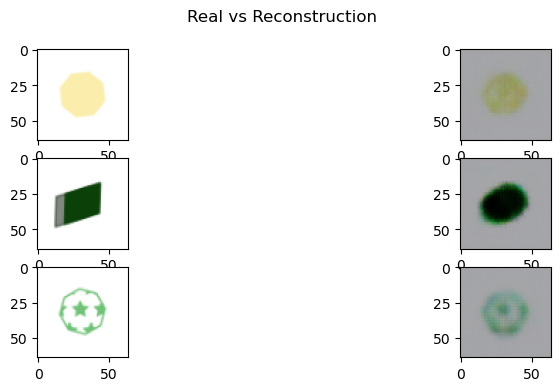

Epoch 1 | train loss 6988.37 | valid loss 5978.67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:31<00:00,  8.85it/s]
Epoch 2:   0%|▋                                                                                                                                                                                         | 1/282 [00:00<00:29,  9.40it/s]

tensor(3.8744, grad_fn=<MseLossBackward0>)
tensor(3.6177, grad_fn=<MseLossBackward0>)


Epoch 2:   1%|██▋                                                                                                                                                                                       | 4/282 [00:00<00:31,  8.72it/s]

tensor(7.3516, grad_fn=<MseLossBackward0>)
tensor(5.2904, grad_fn=<MseLossBackward0>)


Epoch 2:   2%|███▉                                                                                                                                                                                      | 6/282 [00:00<00:28,  9.56it/s]

tensor(4.2532, grad_fn=<MseLossBackward0>)
tensor(5.8763, grad_fn=<MseLossBackward0>)
tensor(5.2849, grad_fn=<MseLossBackward0>)


Epoch 2:   3%|█████▉                                                                                                                                                                                    | 9/282 [00:00<00:30,  9.07it/s]

tensor(4.4620, grad_fn=<MseLossBackward0>)
tensor(4.0623, grad_fn=<MseLossBackward0>)


Epoch 2:   4%|███████▏                                                                                                                                                                                 | 11/282 [00:01<00:30,  8.91it/s]

tensor(5.1990, grad_fn=<MseLossBackward0>)
tensor(5.6730, grad_fn=<MseLossBackward0>)


Epoch 2:   4%|███████▊                                                                                                                                                                                 | 12/282 [00:01<00:31,  8.52it/s]

tensor(5.9511, grad_fn=<MseLossBackward0>)
tensor(5.2856, grad_fn=<MseLossBackward0>)
tensor(4.9958, grad_fn=<MseLossBackward0>)


Epoch 2:   5%|█████████▊                                                                                                                                                                               | 15/282 [00:01<00:30,  8.84it/s]

tensor(5.8282, grad_fn=<MseLossBackward0>)
tensor(5.1302, grad_fn=<MseLossBackward0>)


Epoch 2:   6%|███████████▊                                                                                                                                                                             | 18/282 [00:02<00:31,  8.51it/s]

tensor(5.9489, grad_fn=<MseLossBackward0>)
tensor(4.0050, grad_fn=<MseLossBackward0>)


Epoch 2:   7%|████████████▍                                                                                                                                                                            | 19/282 [00:02<00:30,  8.58it/s]

tensor(4.3942, grad_fn=<MseLossBackward0>)
tensor(3.2672, grad_fn=<MseLossBackward0>)
tensor(4.3490, grad_fn=<MseLossBackward0>)


Epoch 2:   7%|█████████████▊                                                                                                                                                                           | 21/282 [00:02<00:28,  9.20it/s]

tensor(8.5701, grad_fn=<MseLossBackward0>)
tensor(4.7579, grad_fn=<MseLossBackward0>)


Epoch 2:   9%|███████████████▋                                                                                                                                                                         | 24/282 [00:02<00:35,  7.20it/s]

tensor(4.3614, grad_fn=<MseLossBackward0>)
tensor(5.9707, grad_fn=<MseLossBackward0>)


Epoch 2:   9%|████████████████▍                                                                                                                                                                        | 25/282 [00:03<01:00,  4.25it/s]

tensor(3.3766, grad_fn=<MseLossBackward0>)


Epoch 2:   9%|█████████████████                                                                                                                                                                        | 26/282 [00:04<01:44,  2.46it/s]

tensor(5.2765, grad_fn=<MseLossBackward0>)


Epoch 2:  10%|█████████████████▋                                                                                                                                                                       | 27/282 [00:05<02:19,  1.83it/s]

tensor(4.9349, grad_fn=<MseLossBackward0>)


Epoch 2:  10%|██████████████████▎                                                                                                                                                                      | 28/282 [00:06<02:45,  1.53it/s]

tensor(4.5182, grad_fn=<MseLossBackward0>)


Epoch 2:  10%|███████████████████                                                                                                                                                                      | 29/282 [00:07<03:04,  1.37it/s]

tensor(4.5967, grad_fn=<MseLossBackward0>)


Epoch 2:  11%|███████████████████▋                                                                                                                                                                     | 30/282 [00:08<03:16,  1.28it/s]

tensor(4.5164, grad_fn=<MseLossBackward0>)


Epoch 2:  11%|████████████████████▉                                                                                                                                                                    | 32/282 [00:09<02:46,  1.50it/s]

tensor(5.6902, grad_fn=<MseLossBackward0>)
tensor(4.1310, grad_fn=<MseLossBackward0>)


Epoch 2:  12%|██████████████████████▎                                                                                                                                                                  | 34/282 [00:09<01:41,  2.45it/s]

tensor(5.8830, grad_fn=<MseLossBackward0>)
tensor(3.3236, grad_fn=<MseLossBackward0>)


Epoch 2:  13%|███████████████████████▌                                                                                                                                                                 | 36/282 [00:09<01:11,  3.46it/s]

tensor(4.3468, grad_fn=<MseLossBackward0>)
tensor(4.5023, grad_fn=<MseLossBackward0>)


Epoch 2:  13%|████████████████████████▉                                                                                                                                                                | 38/282 [00:10<00:56,  4.33it/s]

tensor(4.0975, grad_fn=<MseLossBackward0>)
tensor(5.5523, grad_fn=<MseLossBackward0>)


Epoch 2:  14%|██████████████████████████▏                                                                                                                                                              | 40/282 [00:10<00:48,  4.97it/s]

tensor(3.9887, grad_fn=<MseLossBackward0>)
tensor(4.7739, grad_fn=<MseLossBackward0>)


Epoch 2:  15%|███████████████████████████▌                                                                                                                                                             | 42/282 [00:10<00:46,  5.17it/s]

tensor(3.5382, grad_fn=<MseLossBackward0>)
tensor(4.8331, grad_fn=<MseLossBackward0>)


Epoch 2:  16%|████████████████████████████▊                                                                                                                                                            | 44/282 [00:11<00:44,  5.39it/s]

tensor(3.7977, grad_fn=<MseLossBackward0>)
tensor(6.4047, grad_fn=<MseLossBackward0>)


Epoch 2:  16%|██████████████████████████████▏                                                                                                                                                          | 46/282 [00:11<00:42,  5.53it/s]

tensor(4.9138, grad_fn=<MseLossBackward0>)
tensor(4.4731, grad_fn=<MseLossBackward0>)


Epoch 2:  17%|███████████████████████████████▍                                                                                                                                                         | 48/282 [00:12<00:41,  5.59it/s]

tensor(4.3645, grad_fn=<MseLossBackward0>)
tensor(2.9638, grad_fn=<MseLossBackward0>)


Epoch 2:  18%|████████████████████████████████▊                                                                                                                                                        | 50/282 [00:12<00:40,  5.69it/s]

tensor(3.7967, grad_fn=<MseLossBackward0>)
tensor(4.9907, grad_fn=<MseLossBackward0>)


Epoch 2:  18%|██████████████████████████████████                                                                                                                                                       | 52/282 [00:12<00:41,  5.48it/s]

tensor(5.5356, grad_fn=<MseLossBackward0>)
tensor(4.6631, grad_fn=<MseLossBackward0>)


Epoch 2:  19%|███████████████████████████████████▍                                                                                                                                                     | 54/282 [00:13<00:44,  5.16it/s]

tensor(4.6137, grad_fn=<MseLossBackward0>)
tensor(4.1740, grad_fn=<MseLossBackward0>)


Epoch 2:  20%|████████████████████████████████████▋                                                                                                                                                    | 56/282 [00:13<00:44,  5.03it/s]

tensor(4.8788, grad_fn=<MseLossBackward0>)


Epoch 2:  20%|█████████████████████████████████████▍                                                                                                                                                   | 57/282 [00:13<00:43,  5.22it/s]

tensor(4.9300, grad_fn=<MseLossBackward0>)
tensor(4.9372, grad_fn=<MseLossBackward0>)


Epoch 2:  21%|██████████████████████████████████████▋                                                                                                                                                  | 59/282 [00:14<00:40,  5.51it/s]

tensor(6.8858, grad_fn=<MseLossBackward0>)
tensor(5.8125, grad_fn=<MseLossBackward0>)


Epoch 2:  22%|████████████████████████████████████████                                                                                                                                                 | 61/282 [00:14<00:40,  5.46it/s]

tensor(4.8212, grad_fn=<MseLossBackward0>)
tensor(5.6384, grad_fn=<MseLossBackward0>)


Epoch 2:  22%|█████████████████████████████████████████▎                                                                                                                                               | 63/282 [00:14<00:38,  5.64it/s]

tensor(4.4843, grad_fn=<MseLossBackward0>)
tensor(3.4757, grad_fn=<MseLossBackward0>)


Epoch 2:  23%|██████████████████████████████████████████▋                                                                                                                                              | 65/282 [00:15<00:39,  5.54it/s]

tensor(5.3975, grad_fn=<MseLossBackward0>)
tensor(3.2905, grad_fn=<MseLossBackward0>)


Epoch 2:  24%|███████████████████████████████████████████▉                                                                                                                                             | 67/282 [00:15<00:38,  5.53it/s]

tensor(5.6985, grad_fn=<MseLossBackward0>)
tensor(4.7360, grad_fn=<MseLossBackward0>)


Epoch 2:  24%|█████████████████████████████████████████████▎                                                                                                                                           | 69/282 [00:15<00:37,  5.64it/s]

tensor(5.5275, grad_fn=<MseLossBackward0>)
tensor(4.6353, grad_fn=<MseLossBackward0>)


Epoch 2:  25%|██████████████████████████████████████████████▌                                                                                                                                          | 71/282 [00:16<00:38,  5.52it/s]

tensor(6.4305, grad_fn=<MseLossBackward0>)
tensor(6.0806, grad_fn=<MseLossBackward0>)


Epoch 2:  26%|███████████████████████████████████████████████▉                                                                                                                                         | 73/282 [00:16<00:37,  5.54it/s]

tensor(3.6178, grad_fn=<MseLossBackward0>)
tensor(2.9098, grad_fn=<MseLossBackward0>)


Epoch 2:  27%|█████████████████████████████████████████████████▏                                                                                                                                       | 75/282 [00:16<00:38,  5.38it/s]

tensor(4.3111, grad_fn=<MseLossBackward0>)
tensor(5.1905, grad_fn=<MseLossBackward0>)


Epoch 2:  27%|██████████████████████████████████████████████████▌                                                                                                                                      | 77/282 [00:17<00:42,  4.86it/s]

tensor(4.8036, grad_fn=<MseLossBackward0>)
tensor(4.7450, grad_fn=<MseLossBackward0>)


Epoch 2:  28%|███████████████████████████████████████████████████▊                                                                                                                                     | 79/282 [00:17<00:38,  5.24it/s]

tensor(4.1030, grad_fn=<MseLossBackward0>)
tensor(3.6568, grad_fn=<MseLossBackward0>)


Epoch 2:  29%|█████████████████████████████████████████████████████▏                                                                                                                                   | 81/282 [00:18<00:41,  4.84it/s]

tensor(4.4648, grad_fn=<MseLossBackward0>)
tensor(3.9619, grad_fn=<MseLossBackward0>)


Epoch 2:  29%|██████████████████████████████████████████████████████▍                                                                                                                                  | 83/282 [00:18<00:38,  5.16it/s]

tensor(3.4656, grad_fn=<MseLossBackward0>)
tensor(4.9342, grad_fn=<MseLossBackward0>)


Epoch 2:  30%|███████████████████████████████████████████████████████▊                                                                                                                                 | 85/282 [00:19<00:40,  4.89it/s]

tensor(4.5279, grad_fn=<MseLossBackward0>)
tensor(3.9524, grad_fn=<MseLossBackward0>)


Epoch 2:  31%|█████████████████████████████████████████████████████████                                                                                                                                | 87/282 [00:19<00:37,  5.16it/s]

tensor(3.9129, grad_fn=<MseLossBackward0>)
tensor(4.0171, grad_fn=<MseLossBackward0>)


Epoch 2:  32%|██████████████████████████████████████████████████████████▍                                                                                                                              | 89/282 [00:19<00:36,  5.32it/s]

tensor(4.4607, grad_fn=<MseLossBackward0>)
tensor(3.7098, grad_fn=<MseLossBackward0>)


Epoch 2:  32%|███████████████████████████████████████████████████████████▋                                                                                                                             | 91/282 [00:20<00:34,  5.46it/s]

tensor(4.2178, grad_fn=<MseLossBackward0>)
tensor(4.1802, grad_fn=<MseLossBackward0>)


Epoch 2:  33%|█████████████████████████████████████████████████████████████                                                                                                                            | 93/282 [00:20<00:34,  5.49it/s]

tensor(6.1261, grad_fn=<MseLossBackward0>)
tensor(3.1445, grad_fn=<MseLossBackward0>)


Epoch 2:  34%|██████████████████████████████████████████████████████████████▎                                                                                                                          | 95/282 [00:20<00:34,  5.48it/s]

tensor(3.8869, grad_fn=<MseLossBackward0>)
tensor(4.4186, grad_fn=<MseLossBackward0>)


Epoch 2:  34%|███████████████████████████████████████████████████████████████▋                                                                                                                         | 97/282 [00:21<00:33,  5.50it/s]

tensor(3.5046, grad_fn=<MseLossBackward0>)
tensor(4.6957, grad_fn=<MseLossBackward0>)


Epoch 2:  35%|████████████████████████████████████████████████████████████████▉                                                                                                                        | 99/282 [00:21<00:32,  5.60it/s]

tensor(6.2791, grad_fn=<MseLossBackward0>)
tensor(5.4529, grad_fn=<MseLossBackward0>)


Epoch 2:  36%|█████████████████████████████████████████████████████████████████▉                                                                                                                      | 101/282 [00:21<00:34,  5.22it/s]

tensor(4.4623, grad_fn=<MseLossBackward0>)
tensor(4.8715, grad_fn=<MseLossBackward0>)


Epoch 2:  37%|███████████████████████████████████████████████████████████████████▏                                                                                                                    | 103/282 [00:22<00:32,  5.44it/s]

tensor(4.2300, grad_fn=<MseLossBackward0>)
tensor(3.7145, grad_fn=<MseLossBackward0>)


Epoch 2:  37%|████████████████████████████████████████████████████████████████████▌                                                                                                                   | 105/282 [00:22<00:33,  5.30it/s]

tensor(5.0323, grad_fn=<MseLossBackward0>)
tensor(4.6308, grad_fn=<MseLossBackward0>)


Epoch 2:  38%|█████████████████████████████████████████████████████████████████████▊                                                                                                                  | 107/282 [00:23<00:33,  5.26it/s]

tensor(4.3295, grad_fn=<MseLossBackward0>)
tensor(5.8159, grad_fn=<MseLossBackward0>)


Epoch 2:  39%|███████████████████████████████████████████████████████████████████████                                                                                                                 | 109/282 [00:23<00:31,  5.52it/s]

tensor(4.7419, grad_fn=<MseLossBackward0>)
tensor(3.8537, grad_fn=<MseLossBackward0>)


Epoch 2:  39%|████████████████████████████████████████████████████████████████████████▍                                                                                                               | 111/282 [00:23<00:30,  5.62it/s]

tensor(3.7212, grad_fn=<MseLossBackward0>)
tensor(5.9442, grad_fn=<MseLossBackward0>)


Epoch 2:  40%|█████████████████████████████████████████████████████████████████████████▋                                                                                                              | 113/282 [00:24<00:29,  5.66it/s]

tensor(4.9233, grad_fn=<MseLossBackward0>)
tensor(3.9555, grad_fn=<MseLossBackward0>)


Epoch 2:  41%|███████████████████████████████████████████████████████████████████████████                                                                                                             | 115/282 [00:24<00:30,  5.51it/s]

tensor(4.1182, grad_fn=<MseLossBackward0>)
tensor(3.7017, grad_fn=<MseLossBackward0>)


Epoch 2:  41%|████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 117/282 [00:24<00:31,  5.17it/s]

tensor(3.7588, grad_fn=<MseLossBackward0>)
tensor(3.1798, grad_fn=<MseLossBackward0>)


Epoch 2:  42%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 119/282 [00:25<00:30,  5.38it/s]

tensor(3.8129, grad_fn=<MseLossBackward0>)
tensor(5.1520, grad_fn=<MseLossBackward0>)


Epoch 2:  43%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 121/282 [00:25<00:32,  4.93it/s]

tensor(4.9109, grad_fn=<MseLossBackward0>)
tensor(3.3111, grad_fn=<MseLossBackward0>)


Epoch 2:  44%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 123/282 [00:26<00:31,  5.10it/s]

tensor(3.5238, grad_fn=<MseLossBackward0>)
tensor(3.3476, grad_fn=<MseLossBackward0>)


Epoch 2:  44%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 125/282 [00:26<00:29,  5.24it/s]

tensor(4.2348, grad_fn=<MseLossBackward0>)
tensor(4.7523, grad_fn=<MseLossBackward0>)


Epoch 2:  45%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 127/282 [00:26<00:28,  5.41it/s]

tensor(4.7243, grad_fn=<MseLossBackward0>)
tensor(5.5768, grad_fn=<MseLossBackward0>)


Epoch 2:  46%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 129/282 [00:27<00:28,  5.42it/s]

tensor(3.8016, grad_fn=<MseLossBackward0>)
tensor(4.1912, grad_fn=<MseLossBackward0>)


Epoch 2:  46%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 131/282 [00:27<00:27,  5.45it/s]

tensor(4.0930, grad_fn=<MseLossBackward0>)
tensor(4.0302, grad_fn=<MseLossBackward0>)


Epoch 2:  47%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 133/282 [00:27<00:27,  5.32it/s]

tensor(4.0816, grad_fn=<MseLossBackward0>)
tensor(4.3841, grad_fn=<MseLossBackward0>)


Epoch 2:  48%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 135/282 [00:28<00:27,  5.30it/s]

tensor(3.4416, grad_fn=<MseLossBackward0>)
tensor(4.4169, grad_fn=<MseLossBackward0>)


Epoch 2:  49%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 137/282 [00:28<00:26,  5.46it/s]

tensor(3.1034, grad_fn=<MseLossBackward0>)
tensor(4.7862, grad_fn=<MseLossBackward0>)


Epoch 2:  49%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 139/282 [00:29<00:26,  5.48it/s]

tensor(4.2668, grad_fn=<MseLossBackward0>)
tensor(4.8897, grad_fn=<MseLossBackward0>)


Epoch 2:  50%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 141/282 [00:29<00:25,  5.50it/s]

tensor(4.0562, grad_fn=<MseLossBackward0>)
tensor(3.7021, grad_fn=<MseLossBackward0>)


Epoch 2:  51%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 143/282 [00:29<00:25,  5.36it/s]

tensor(4.7908, grad_fn=<MseLossBackward0>)
tensor(3.7743, grad_fn=<MseLossBackward0>)


Epoch 2:  51%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 145/282 [00:30<00:25,  5.30it/s]

tensor(4.0090, grad_fn=<MseLossBackward0>)
tensor(5.3756, grad_fn=<MseLossBackward0>)


Epoch 2:  52%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 147/282 [00:30<00:25,  5.35it/s]

tensor(4.4930, grad_fn=<MseLossBackward0>)
tensor(5.7656, grad_fn=<MseLossBackward0>)


Epoch 2:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 149/282 [00:30<00:24,  5.43it/s]

tensor(4.7651, grad_fn=<MseLossBackward0>)
tensor(3.9529, grad_fn=<MseLossBackward0>)


Epoch 2:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 151/282 [00:31<00:23,  5.63it/s]

tensor(3.8830, grad_fn=<MseLossBackward0>)
tensor(4.1193, grad_fn=<MseLossBackward0>)


Epoch 2:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 153/282 [00:31<00:23,  5.49it/s]

tensor(3.7319, grad_fn=<MseLossBackward0>)
tensor(4.4450, grad_fn=<MseLossBackward0>)


Epoch 2:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 155/282 [00:32<00:23,  5.40it/s]

tensor(3.9654, grad_fn=<MseLossBackward0>)
tensor(4.8598, grad_fn=<MseLossBackward0>)


Epoch 2:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 157/282 [00:32<00:23,  5.37it/s]

tensor(4.1695, grad_fn=<MseLossBackward0>)
tensor(4.4657, grad_fn=<MseLossBackward0>)


Epoch 2:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 159/282 [00:32<00:22,  5.44it/s]

tensor(4.2012, grad_fn=<MseLossBackward0>)
tensor(4.9253, grad_fn=<MseLossBackward0>)


Epoch 2:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 161/282 [00:33<00:21,  5.54it/s]

tensor(6.4493, grad_fn=<MseLossBackward0>)
tensor(5.5700, grad_fn=<MseLossBackward0>)


Epoch 2:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 163/282 [00:33<00:21,  5.50it/s]

tensor(3.4725, grad_fn=<MseLossBackward0>)
tensor(4.9278, grad_fn=<MseLossBackward0>)


Epoch 2:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 165/282 [00:33<00:20,  5.59it/s]

tensor(4.0198, grad_fn=<MseLossBackward0>)
tensor(4.2860, grad_fn=<MseLossBackward0>)


Epoch 2:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 167/282 [00:34<00:20,  5.64it/s]

tensor(3.5881, grad_fn=<MseLossBackward0>)
tensor(3.8833, grad_fn=<MseLossBackward0>)


Epoch 2:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 169/282 [00:34<00:19,  5.68it/s]

tensor(4.8978, grad_fn=<MseLossBackward0>)
tensor(4.1158, grad_fn=<MseLossBackward0>)


Epoch 2:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 171/282 [00:34<00:20,  5.53it/s]

tensor(4.5647, grad_fn=<MseLossBackward0>)
tensor(5.8163, grad_fn=<MseLossBackward0>)


Epoch 2:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 173/282 [00:35<00:19,  5.60it/s]

tensor(3.3035, grad_fn=<MseLossBackward0>)
tensor(2.6793, grad_fn=<MseLossBackward0>)


Epoch 2:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 175/282 [00:35<00:19,  5.58it/s]

tensor(3.6679, grad_fn=<MseLossBackward0>)
tensor(5.0620, grad_fn=<MseLossBackward0>)


Epoch 2:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 177/282 [00:35<00:18,  5.62it/s]

tensor(4.4259, grad_fn=<MseLossBackward0>)
tensor(3.9189, grad_fn=<MseLossBackward0>)


Epoch 2:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 179/282 [00:36<00:17,  5.80it/s]

tensor(6.1715, grad_fn=<MseLossBackward0>)
tensor(6.9459, grad_fn=<MseLossBackward0>)


Epoch 2:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 181/282 [00:36<00:17,  5.94it/s]

tensor(3.3146, grad_fn=<MseLossBackward0>)
tensor(4.1676, grad_fn=<MseLossBackward0>)


Epoch 2:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 183/282 [00:36<00:17,  5.79it/s]

tensor(3.3109, grad_fn=<MseLossBackward0>)
tensor(5.8381, grad_fn=<MseLossBackward0>)


Epoch 2:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 185/282 [00:37<00:17,  5.54it/s]

tensor(4.4197, grad_fn=<MseLossBackward0>)
tensor(3.3239, grad_fn=<MseLossBackward0>)


Epoch 2:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 187/282 [00:37<00:17,  5.58it/s]

tensor(2.5230, grad_fn=<MseLossBackward0>)
tensor(4.1074, grad_fn=<MseLossBackward0>)


Epoch 2:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 189/282 [00:38<00:16,  5.60it/s]

tensor(3.7469, grad_fn=<MseLossBackward0>)
tensor(4.0742, grad_fn=<MseLossBackward0>)


Epoch 2:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 191/282 [00:38<00:16,  5.64it/s]

tensor(3.7417, grad_fn=<MseLossBackward0>)
tensor(4.2691, grad_fn=<MseLossBackward0>)


Epoch 2:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 193/282 [00:38<00:16,  5.49it/s]

tensor(4.1845, grad_fn=<MseLossBackward0>)
tensor(4.3880, grad_fn=<MseLossBackward0>)


Epoch 2:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 195/282 [00:39<00:15,  5.55it/s]

tensor(4.0383, grad_fn=<MseLossBackward0>)
tensor(2.7188, grad_fn=<MseLossBackward0>)


Epoch 2:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 197/282 [00:39<00:15,  5.62it/s]

tensor(4.0433, grad_fn=<MseLossBackward0>)
tensor(5.0010, grad_fn=<MseLossBackward0>)


Epoch 2:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 199/282 [00:39<00:14,  5.81it/s]

tensor(4.3015, grad_fn=<MseLossBackward0>)
tensor(4.5993, grad_fn=<MseLossBackward0>)


Epoch 2:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 201/282 [00:40<00:14,  5.65it/s]

tensor(3.9159, grad_fn=<MseLossBackward0>)
tensor(4.1825, grad_fn=<MseLossBackward0>)


Epoch 2:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 203/282 [00:40<00:14,  5.55it/s]

tensor(5.9154, grad_fn=<MseLossBackward0>)
tensor(4.0359, grad_fn=<MseLossBackward0>)


Epoch 2:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 205/282 [00:40<00:13,  5.60it/s]

tensor(3.0726, grad_fn=<MseLossBackward0>)
tensor(4.8867, grad_fn=<MseLossBackward0>)


Epoch 2:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 207/282 [00:41<00:13,  5.43it/s]

tensor(4.7267, grad_fn=<MseLossBackward0>)
tensor(3.3353, grad_fn=<MseLossBackward0>)


Epoch 2:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 209/282 [00:41<00:13,  5.54it/s]

tensor(4.7988, grad_fn=<MseLossBackward0>)
tensor(4.3839, grad_fn=<MseLossBackward0>)


Epoch 2:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 211/282 [00:41<00:12,  5.82it/s]

tensor(4.3491, grad_fn=<MseLossBackward0>)
tensor(4.8085, grad_fn=<MseLossBackward0>)


Epoch 2:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 213/282 [00:42<00:12,  5.65it/s]

tensor(3.2117, grad_fn=<MseLossBackward0>)
tensor(4.5958, grad_fn=<MseLossBackward0>)


Epoch 2:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 215/282 [00:42<00:11,  5.59it/s]

tensor(4.7322, grad_fn=<MseLossBackward0>)
tensor(2.6415, grad_fn=<MseLossBackward0>)


Epoch 2:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 217/282 [00:43<00:11,  5.64it/s]

tensor(2.9785, grad_fn=<MseLossBackward0>)
tensor(3.6792, grad_fn=<MseLossBackward0>)


Epoch 2:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 219/282 [00:43<00:10,  5.89it/s]

tensor(3.8238, grad_fn=<MseLossBackward0>)
tensor(3.7743, grad_fn=<MseLossBackward0>)


Epoch 2:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 221/282 [00:43<00:10,  5.65it/s]

tensor(2.7318, grad_fn=<MseLossBackward0>)
tensor(3.4119, grad_fn=<MseLossBackward0>)


Epoch 2:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 223/282 [00:44<00:10,  5.66it/s]

tensor(4.0658, grad_fn=<MseLossBackward0>)
tensor(3.1604, grad_fn=<MseLossBackward0>)


Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 225/282 [00:44<00:10,  5.60it/s]

tensor(3.4423, grad_fn=<MseLossBackward0>)
tensor(3.4558, grad_fn=<MseLossBackward0>)


Epoch 2:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 227/282 [00:44<00:09,  5.60it/s]

tensor(4.0588, grad_fn=<MseLossBackward0>)
tensor(4.0974, grad_fn=<MseLossBackward0>)


Epoch 2:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 229/282 [00:45<00:09,  5.71it/s]

tensor(4.8160, grad_fn=<MseLossBackward0>)
tensor(3.1444, grad_fn=<MseLossBackward0>)


Epoch 2:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 231/282 [00:45<00:08,  5.77it/s]

tensor(4.8253, grad_fn=<MseLossBackward0>)
tensor(3.3722, grad_fn=<MseLossBackward0>)


Epoch 2:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 233/282 [00:45<00:08,  5.71it/s]

tensor(3.8163, grad_fn=<MseLossBackward0>)
tensor(4.5239, grad_fn=<MseLossBackward0>)


Epoch 2:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 235/282 [00:46<00:08,  5.62it/s]

tensor(4.4387, grad_fn=<MseLossBackward0>)
tensor(2.9313, grad_fn=<MseLossBackward0>)


Epoch 2:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 237/282 [00:46<00:08,  5.57it/s]

tensor(4.9218, grad_fn=<MseLossBackward0>)
tensor(2.9811, grad_fn=<MseLossBackward0>)


Epoch 2:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 239/282 [00:46<00:07,  5.46it/s]

tensor(3.6277, grad_fn=<MseLossBackward0>)
tensor(3.0978, grad_fn=<MseLossBackward0>)


Epoch 2:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 241/282 [00:47<00:07,  5.37it/s]

tensor(4.3214, grad_fn=<MseLossBackward0>)
tensor(3.4089, grad_fn=<MseLossBackward0>)


Epoch 2:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 243/282 [00:47<00:07,  5.56it/s]

tensor(3.2733, grad_fn=<MseLossBackward0>)
tensor(4.0173, grad_fn=<MseLossBackward0>)


Epoch 2:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 245/282 [00:48<00:06,  5.63it/s]

tensor(4.1159, grad_fn=<MseLossBackward0>)
tensor(4.8240, grad_fn=<MseLossBackward0>)


Epoch 2:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 247/282 [00:48<00:06,  5.48it/s]

tensor(3.6584, grad_fn=<MseLossBackward0>)
tensor(5.3540, grad_fn=<MseLossBackward0>)


Epoch 2:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 249/282 [00:48<00:06,  5.21it/s]

tensor(3.6716, grad_fn=<MseLossBackward0>)
tensor(4.2098, grad_fn=<MseLossBackward0>)


Epoch 2:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 251/282 [00:49<00:05,  5.37it/s]

tensor(3.2880, grad_fn=<MseLossBackward0>)
tensor(3.1851, grad_fn=<MseLossBackward0>)


Epoch 2:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 253/282 [00:49<00:05,  5.18it/s]

tensor(3.9688, grad_fn=<MseLossBackward0>)


Epoch 2:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 254/282 [00:49<00:05,  5.20it/s]

tensor(4.3171, grad_fn=<MseLossBackward0>)
tensor(3.9608, grad_fn=<MseLossBackward0>)


Epoch 2:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 256/282 [00:50<00:04,  5.32it/s]

tensor(4.2906, grad_fn=<MseLossBackward0>)
tensor(4.7168, grad_fn=<MseLossBackward0>)


Epoch 2:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 258/282 [00:50<00:04,  5.49it/s]

tensor(3.6160, grad_fn=<MseLossBackward0>)
tensor(3.7063, grad_fn=<MseLossBackward0>)


Epoch 2:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 260/282 [00:50<00:04,  5.35it/s]

tensor(5.5561, grad_fn=<MseLossBackward0>)
tensor(4.2865, grad_fn=<MseLossBackward0>)


Epoch 2:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 262/282 [00:51<00:03,  5.41it/s]

tensor(4.8511, grad_fn=<MseLossBackward0>)
tensor(3.9969, grad_fn=<MseLossBackward0>)


Epoch 2:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 264/282 [00:51<00:03,  5.47it/s]

tensor(3.8721, grad_fn=<MseLossBackward0>)
tensor(4.2755, grad_fn=<MseLossBackward0>)


Epoch 2:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 266/282 [00:51<00:03,  5.25it/s]

tensor(4.7117, grad_fn=<MseLossBackward0>)
tensor(4.5952, grad_fn=<MseLossBackward0>)


Epoch 2:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 268/282 [00:52<00:02,  5.38it/s]

tensor(3.6845, grad_fn=<MseLossBackward0>)
tensor(4.3261, grad_fn=<MseLossBackward0>)


Epoch 2:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 270/282 [00:52<00:02,  5.39it/s]

tensor(4.0944, grad_fn=<MseLossBackward0>)
tensor(4.4840, grad_fn=<MseLossBackward0>)


Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 272/282 [00:53<00:01,  5.44it/s]

tensor(3.8005, grad_fn=<MseLossBackward0>)
tensor(5.0360, grad_fn=<MseLossBackward0>)


Epoch 2:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 274/282 [00:53<00:01,  5.30it/s]

tensor(3.5824, grad_fn=<MseLossBackward0>)
tensor(2.9997, grad_fn=<MseLossBackward0>)


Epoch 2:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 276/282 [00:53<00:01,  5.38it/s]

tensor(4.6613, grad_fn=<MseLossBackward0>)
tensor(4.1852, grad_fn=<MseLossBackward0>)


Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 278/282 [00:54<00:00,  5.42it/s]

tensor(5.4162, grad_fn=<MseLossBackward0>)
tensor(4.0020, grad_fn=<MseLossBackward0>)


Epoch 2:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 280/282 [00:54<00:00,  5.41it/s]

tensor(3.4159, grad_fn=<MseLossBackward0>)
tensor(4.0026, grad_fn=<MseLossBackward0>)


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:54<00:00,  5.28it/s]

tensor(2.1727, grad_fn=<MseLossBackward0>)
tensor(5.8229)
tensor(6.1314)
tensor(6.0777)
tensor(5.5575)
tensor(7.0576)
tensor(5.4525)
tensor(7.7604)
tensor(5.9376)
tensor(6.6095)
tensor(5.9561)
tensor(5.9144)
tensor(6.1998)
tensor(6.8318)
tensor(5.2262)
tensor(6.2944)
tensor(6.4176)
tensor(5.3165)
tensor(5.9385)
tensor(5.9492)
tensor(6.5290)
tensor(7.2257)
tensor(6.4340)
tensor(6.0522)
tensor(6.4119)
tensor(5.1133)
tensor(6.1122)
tensor(6.6045)
tensor(8.2703)
tensor(6.7401)
tensor(5.1543)
tensor(6.8577)
tensor(2.3744)


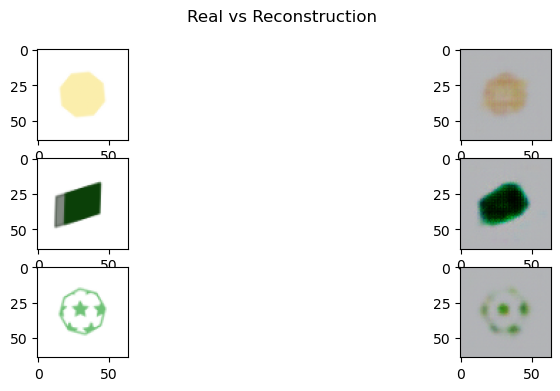

Epoch 2 | train loss 5508.59 | valid loss 5084.33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:57<00:00,  4.88it/s]
Epoch 3:   0%|▋                                                                                                                                                                                         | 1/282 [00:00<01:04,  4.37it/s]

tensor(4.5228, grad_fn=<MseLossBackward0>)
tensor(4.2640, grad_fn=<MseLossBackward0>)


Epoch 3:   1%|█▉                                                                                                                                                                                        | 3/282 [00:00<00:52,  5.34it/s]

tensor(4.0890, grad_fn=<MseLossBackward0>)
tensor(3.2504, grad_fn=<MseLossBackward0>)


Epoch 3:   2%|███▎                                                                                                                                                                                      | 5/282 [00:00<00:50,  5.48it/s]

tensor(4.5476, grad_fn=<MseLossBackward0>)
tensor(3.1556, grad_fn=<MseLossBackward0>)


Epoch 3:   2%|████▌                                                                                                                                                                                     | 7/282 [00:01<00:49,  5.55it/s]

tensor(3.2248, grad_fn=<MseLossBackward0>)
tensor(3.8896, grad_fn=<MseLossBackward0>)


Epoch 3:   3%|█████▉                                                                                                                                                                                    | 9/282 [00:01<00:49,  5.53it/s]

tensor(4.6591, grad_fn=<MseLossBackward0>)
tensor(3.7548, grad_fn=<MseLossBackward0>)


Epoch 3:   4%|███████▏                                                                                                                                                                                 | 11/282 [00:02<00:49,  5.46it/s]

tensor(4.7981, grad_fn=<MseLossBackward0>)


Epoch 3:   4%|███████▊                                                                                                                                                                                 | 12/282 [00:02<00:54,  4.94it/s]

tensor(5.1993, grad_fn=<MseLossBackward0>)


Epoch 3:   5%|████████▌                                                                                                                                                                                | 13/282 [00:02<00:54,  4.96it/s]

tensor(4.3233, grad_fn=<MseLossBackward0>)
tensor(3.5815, grad_fn=<MseLossBackward0>)


Epoch 3:   5%|█████████▊                                                                                                                                                                               | 15/282 [00:02<00:49,  5.43it/s]

tensor(3.3119, grad_fn=<MseLossBackward0>)
tensor(3.0816, grad_fn=<MseLossBackward0>)


Epoch 3:   6%|███████████▏                                                                                                                                                                             | 17/282 [00:03<00:52,  5.01it/s]

tensor(3.3261, grad_fn=<MseLossBackward0>)
tensor(3.7006, grad_fn=<MseLossBackward0>)


Epoch 3:   7%|████████████▍                                                                                                                                                                            | 19/282 [00:03<00:49,  5.29it/s]

tensor(4.6984, grad_fn=<MseLossBackward0>)
tensor(3.7726, grad_fn=<MseLossBackward0>)


Epoch 3:   7%|█████████████▊                                                                                                                                                                           | 21/282 [00:03<00:48,  5.36it/s]

tensor(2.9151, grad_fn=<MseLossBackward0>)
tensor(3.6639, grad_fn=<MseLossBackward0>)


Epoch 3:   8%|███████████████                                                                                                                                                                          | 23/282 [00:04<00:48,  5.32it/s]

tensor(4.6529, grad_fn=<MseLossBackward0>)
tensor(5.3343, grad_fn=<MseLossBackward0>)


Epoch 3:   9%|████████████████▍                                                                                                                                                                        | 25/282 [00:04<00:46,  5.48it/s]

tensor(3.1671, grad_fn=<MseLossBackward0>)
tensor(4.0530, grad_fn=<MseLossBackward0>)


Epoch 3:  10%|█████████████████▋                                                                                                                                                                       | 27/282 [00:05<00:46,  5.44it/s]

tensor(3.3948, grad_fn=<MseLossBackward0>)
tensor(3.6349, grad_fn=<MseLossBackward0>)


Epoch 3:  10%|███████████████████                                                                                                                                                                      | 29/282 [00:05<00:45,  5.56it/s]

tensor(5.4827, grad_fn=<MseLossBackward0>)
tensor(3.6144, grad_fn=<MseLossBackward0>)


Epoch 3:  11%|████████████████████▎                                                                                                                                                                    | 31/282 [00:05<00:44,  5.61it/s]

tensor(3.7003, grad_fn=<MseLossBackward0>)
tensor(4.6721, grad_fn=<MseLossBackward0>)


Epoch 3:  12%|█████████████████████▋                                                                                                                                                                   | 33/282 [00:06<00:45,  5.53it/s]

tensor(4.2996, grad_fn=<MseLossBackward0>)
tensor(4.2647, grad_fn=<MseLossBackward0>)


Epoch 3:  12%|██████████████████████▉                                                                                                                                                                  | 35/282 [00:06<00:44,  5.54it/s]

tensor(3.7930, grad_fn=<MseLossBackward0>)
tensor(3.9631, grad_fn=<MseLossBackward0>)


Epoch 3:  13%|████████████████████████▎                                                                                                                                                                | 37/282 [00:06<00:44,  5.52it/s]

tensor(4.3725, grad_fn=<MseLossBackward0>)
tensor(3.1850, grad_fn=<MseLossBackward0>)


Epoch 3:  14%|█████████████████████████▌                                                                                                                                                               | 39/282 [00:07<00:44,  5.51it/s]

tensor(3.2891, grad_fn=<MseLossBackward0>)
tensor(4.4536, grad_fn=<MseLossBackward0>)


Epoch 3:  15%|██████████████████████████▉                                                                                                                                                              | 41/282 [00:07<00:43,  5.50it/s]

tensor(3.8840, grad_fn=<MseLossBackward0>)
tensor(3.8907, grad_fn=<MseLossBackward0>)


Epoch 3:  15%|████████████████████████████▏                                                                                                                                                            | 43/282 [00:07<00:42,  5.59it/s]

tensor(4.3141, grad_fn=<MseLossBackward0>)
tensor(5.5775, grad_fn=<MseLossBackward0>)


Epoch 3:  16%|█████████████████████████████▌                                                                                                                                                           | 45/282 [00:08<00:41,  5.66it/s]

tensor(4.0157, grad_fn=<MseLossBackward0>)
tensor(4.3555, grad_fn=<MseLossBackward0>)


Epoch 3:  17%|██████████████████████████████▊                                                                                                                                                          | 47/282 [00:08<00:43,  5.42it/s]

tensor(3.1174, grad_fn=<MseLossBackward0>)
tensor(3.9702, grad_fn=<MseLossBackward0>)


Epoch 3:  17%|████████████████████████████████▏                                                                                                                                                        | 49/282 [00:09<00:43,  5.41it/s]

tensor(4.3615, grad_fn=<MseLossBackward0>)
tensor(3.7928, grad_fn=<MseLossBackward0>)


Epoch 3:  18%|█████████████████████████████████▍                                                                                                                                                       | 51/282 [00:09<00:41,  5.56it/s]

tensor(3.4125, grad_fn=<MseLossBackward0>)
tensor(5.4081, grad_fn=<MseLossBackward0>)


Epoch 3:  19%|██████████████████████████████████▊                                                                                                                                                      | 53/282 [00:09<00:41,  5.50it/s]

tensor(2.9223, grad_fn=<MseLossBackward0>)
tensor(3.2409, grad_fn=<MseLossBackward0>)


Epoch 3:  20%|████████████████████████████████████                                                                                                                                                     | 55/282 [00:10<00:41,  5.46it/s]

tensor(3.9448, grad_fn=<MseLossBackward0>)
tensor(4.1897, grad_fn=<MseLossBackward0>)


Epoch 3:  20%|█████████████████████████████████████▍                                                                                                                                                   | 57/282 [00:10<00:40,  5.57it/s]

tensor(4.3861, grad_fn=<MseLossBackward0>)
tensor(3.3863, grad_fn=<MseLossBackward0>)


Epoch 3:  21%|██████████████████████████████████████▋                                                                                                                                                  | 59/282 [00:10<00:41,  5.34it/s]

tensor(2.2430, grad_fn=<MseLossBackward0>)
tensor(3.3022, grad_fn=<MseLossBackward0>)


Epoch 3:  22%|████████████████████████████████████████                                                                                                                                                 | 61/282 [00:11<00:40,  5.42it/s]

tensor(4.6446, grad_fn=<MseLossBackward0>)
tensor(4.3695, grad_fn=<MseLossBackward0>)


Epoch 3:  22%|█████████████████████████████████████████▎                                                                                                                                               | 63/282 [00:11<00:39,  5.51it/s]

tensor(4.8766, grad_fn=<MseLossBackward0>)
tensor(3.4849, grad_fn=<MseLossBackward0>)


Epoch 3:  23%|██████████████████████████████████████████▋                                                                                                                                              | 65/282 [00:11<00:39,  5.52it/s]

tensor(2.9265, grad_fn=<MseLossBackward0>)
tensor(2.9631, grad_fn=<MseLossBackward0>)


Epoch 3:  24%|███████████████████████████████████████████▉                                                                                                                                             | 67/282 [00:12<00:39,  5.51it/s]

tensor(3.8570, grad_fn=<MseLossBackward0>)
tensor(3.9437, grad_fn=<MseLossBackward0>)


Epoch 3:  24%|█████████████████████████████████████████████▎                                                                                                                                           | 69/282 [00:12<00:39,  5.41it/s]

tensor(3.2387, grad_fn=<MseLossBackward0>)
tensor(4.1074, grad_fn=<MseLossBackward0>)


Epoch 3:  25%|██████████████████████████████████████████████▌                                                                                                                                          | 71/282 [00:13<00:38,  5.43it/s]

tensor(4.3151, grad_fn=<MseLossBackward0>)
tensor(3.0144, grad_fn=<MseLossBackward0>)


Epoch 3:  26%|███████████████████████████████████████████████▉                                                                                                                                         | 73/282 [00:13<00:38,  5.49it/s]

tensor(3.6764, grad_fn=<MseLossBackward0>)
tensor(3.8809, grad_fn=<MseLossBackward0>)


Epoch 3:  27%|█████████████████████████████████████████████████▏                                                                                                                                       | 75/282 [00:13<00:37,  5.50it/s]

tensor(3.0467, grad_fn=<MseLossBackward0>)
tensor(4.1653, grad_fn=<MseLossBackward0>)


Epoch 3:  27%|██████████████████████████████████████████████████▌                                                                                                                                      | 77/282 [00:14<00:37,  5.42it/s]

tensor(2.5149, grad_fn=<MseLossBackward0>)
tensor(3.2217, grad_fn=<MseLossBackward0>)


Epoch 3:  28%|███████████████████████████████████████████████████▊                                                                                                                                     | 79/282 [00:14<00:36,  5.56it/s]

tensor(4.1651, grad_fn=<MseLossBackward0>)
tensor(4.0917, grad_fn=<MseLossBackward0>)


Epoch 3:  29%|█████████████████████████████████████████████████████▏                                                                                                                                   | 81/282 [00:14<00:36,  5.49it/s]

tensor(4.2384, grad_fn=<MseLossBackward0>)
tensor(3.2709, grad_fn=<MseLossBackward0>)


Epoch 3:  29%|██████████████████████████████████████████████████████▍                                                                                                                                  | 83/282 [00:15<00:36,  5.46it/s]

tensor(4.4262, grad_fn=<MseLossBackward0>)
tensor(2.9914, grad_fn=<MseLossBackward0>)


Epoch 3:  30%|███████████████████████████████████████████████████████▊                                                                                                                                 | 85/282 [00:15<00:37,  5.19it/s]

tensor(4.1939, grad_fn=<MseLossBackward0>)
tensor(2.4058, grad_fn=<MseLossBackward0>)


Epoch 3:  31%|█████████████████████████████████████████████████████████                                                                                                                                | 87/282 [00:16<00:39,  4.98it/s]

tensor(4.7327, grad_fn=<MseLossBackward0>)
tensor(3.8185, grad_fn=<MseLossBackward0>)


Epoch 3:  32%|██████████████████████████████████████████████████████████▍                                                                                                                              | 89/282 [00:16<00:36,  5.29it/s]

tensor(2.9007, grad_fn=<MseLossBackward0>)
tensor(4.0291, grad_fn=<MseLossBackward0>)


Epoch 3:  32%|███████████████████████████████████████████████████████████▋                                                                                                                             | 91/282 [00:16<00:35,  5.42it/s]

tensor(3.2813, grad_fn=<MseLossBackward0>)
tensor(3.4249, grad_fn=<MseLossBackward0>)


Epoch 3:  33%|█████████████████████████████████████████████████████████████                                                                                                                            | 93/282 [00:17<00:33,  5.58it/s]

tensor(4.4577, grad_fn=<MseLossBackward0>)
tensor(4.0969, grad_fn=<MseLossBackward0>)


Epoch 3:  34%|██████████████████████████████████████████████████████████████▎                                                                                                                          | 95/282 [00:17<00:33,  5.56it/s]

tensor(3.2775, grad_fn=<MseLossBackward0>)
tensor(3.2701, grad_fn=<MseLossBackward0>)


Epoch 3:  34%|███████████████████████████████████████████████████████████████▋                                                                                                                         | 97/282 [00:17<00:32,  5.65it/s]

tensor(4.0940, grad_fn=<MseLossBackward0>)
tensor(3.4436, grad_fn=<MseLossBackward0>)


Epoch 3:  35%|████████████████████████████████████████████████████████████████▉                                                                                                                        | 99/282 [00:18<00:32,  5.61it/s]

tensor(4.1888, grad_fn=<MseLossBackward0>)
tensor(4.8442, grad_fn=<MseLossBackward0>)


Epoch 3:  36%|█████████████████████████████████████████████████████████████████▉                                                                                                                      | 101/282 [00:18<00:33,  5.46it/s]

tensor(4.0538, grad_fn=<MseLossBackward0>)
tensor(2.9251, grad_fn=<MseLossBackward0>)


Epoch 3:  37%|███████████████████████████████████████████████████████████████████▏                                                                                                                    | 103/282 [00:18<00:32,  5.48it/s]

tensor(3.9463, grad_fn=<MseLossBackward0>)
tensor(3.3004, grad_fn=<MseLossBackward0>)


Epoch 3:  37%|████████████████████████████████████████████████████████████████████▌                                                                                                                   | 105/282 [00:19<00:33,  5.35it/s]

tensor(3.0429, grad_fn=<MseLossBackward0>)
tensor(4.0998, grad_fn=<MseLossBackward0>)


Epoch 3:  38%|█████████████████████████████████████████████████████████████████████▊                                                                                                                  | 107/282 [00:19<00:31,  5.51it/s]

tensor(4.2702, grad_fn=<MseLossBackward0>)
tensor(4.2468, grad_fn=<MseLossBackward0>)


Epoch 3:  39%|███████████████████████████████████████████████████████████████████████                                                                                                                 | 109/282 [00:20<00:31,  5.46it/s]

tensor(3.7462, grad_fn=<MseLossBackward0>)
tensor(3.8084, grad_fn=<MseLossBackward0>)


Epoch 3:  39%|████████████████████████████████████████████████████████████████████████▍                                                                                                               | 111/282 [00:20<00:31,  5.48it/s]

tensor(3.6705, grad_fn=<MseLossBackward0>)
tensor(4.3681, grad_fn=<MseLossBackward0>)


Epoch 3:  40%|█████████████████████████████████████████████████████████████████████████▋                                                                                                              | 113/282 [00:20<00:31,  5.37it/s]

tensor(3.3438, grad_fn=<MseLossBackward0>)
tensor(2.8883, grad_fn=<MseLossBackward0>)


Epoch 3:  41%|███████████████████████████████████████████████████████████████████████████                                                                                                             | 115/282 [00:21<00:30,  5.45it/s]

tensor(2.8976, grad_fn=<MseLossBackward0>)
tensor(2.8361, grad_fn=<MseLossBackward0>)


Epoch 3:  41%|████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 117/282 [00:21<00:29,  5.58it/s]

tensor(3.7942, grad_fn=<MseLossBackward0>)
tensor(3.8401, grad_fn=<MseLossBackward0>)


Epoch 3:  42%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 119/282 [00:21<00:29,  5.49it/s]

tensor(3.6003, grad_fn=<MseLossBackward0>)
tensor(3.1925, grad_fn=<MseLossBackward0>)


Epoch 3:  43%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 121/282 [00:22<00:29,  5.53it/s]

tensor(4.2032, grad_fn=<MseLossBackward0>)
tensor(3.6194, grad_fn=<MseLossBackward0>)


Epoch 3:  44%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 123/282 [00:22<00:28,  5.55it/s]

tensor(2.8319, grad_fn=<MseLossBackward0>)
tensor(3.4181, grad_fn=<MseLossBackward0>)


Epoch 3:  44%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 125/282 [00:23<00:29,  5.34it/s]

tensor(3.9420, grad_fn=<MseLossBackward0>)
tensor(3.2368, grad_fn=<MseLossBackward0>)


Epoch 3:  45%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 127/282 [00:23<00:28,  5.49it/s]

tensor(3.9362, grad_fn=<MseLossBackward0>)
tensor(5.0542, grad_fn=<MseLossBackward0>)


Epoch 3:  46%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 129/282 [00:23<00:28,  5.39it/s]

tensor(3.3445, grad_fn=<MseLossBackward0>)
tensor(2.6585, grad_fn=<MseLossBackward0>)


Epoch 3:  46%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 131/282 [00:24<00:27,  5.58it/s]

tensor(3.3259, grad_fn=<MseLossBackward0>)
tensor(3.0849, grad_fn=<MseLossBackward0>)


Epoch 3:  47%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 133/282 [00:24<00:27,  5.43it/s]

tensor(3.2720, grad_fn=<MseLossBackward0>)
tensor(3.4532, grad_fn=<MseLossBackward0>)


Epoch 3:  48%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 135/282 [00:24<00:27,  5.44it/s]

tensor(2.6926, grad_fn=<MseLossBackward0>)
tensor(3.0688, grad_fn=<MseLossBackward0>)


Epoch 3:  49%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 137/282 [00:25<00:26,  5.57it/s]

tensor(3.9842, grad_fn=<MseLossBackward0>)
tensor(3.8017, grad_fn=<MseLossBackward0>)


Epoch 3:  49%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 139/282 [00:25<00:25,  5.53it/s]

tensor(3.4680, grad_fn=<MseLossBackward0>)
tensor(3.5931, grad_fn=<MseLossBackward0>)


Epoch 3:  50%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 141/282 [00:25<00:24,  5.79it/s]

tensor(2.9015, grad_fn=<MseLossBackward0>)
tensor(3.6699, grad_fn=<MseLossBackward0>)


Epoch 3:  51%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 143/282 [00:26<00:24,  5.76it/s]

tensor(2.9896, grad_fn=<MseLossBackward0>)
tensor(2.9746, grad_fn=<MseLossBackward0>)


Epoch 3:  51%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 145/282 [00:26<00:23,  5.71it/s]

tensor(3.7614, grad_fn=<MseLossBackward0>)
tensor(3.1748, grad_fn=<MseLossBackward0>)


Epoch 3:  52%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 147/282 [00:27<00:25,  5.32it/s]

tensor(3.7926, grad_fn=<MseLossBackward0>)
tensor(2.8224, grad_fn=<MseLossBackward0>)


Epoch 3:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 149/282 [00:27<00:23,  5.58it/s]

tensor(3.7976, grad_fn=<MseLossBackward0>)
tensor(2.5958, grad_fn=<MseLossBackward0>)


Epoch 3:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 151/282 [00:27<00:23,  5.47it/s]

tensor(3.5659, grad_fn=<MseLossBackward0>)
tensor(3.7191, grad_fn=<MseLossBackward0>)


Epoch 3:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 153/282 [00:28<00:23,  5.50it/s]

tensor(3.5939, grad_fn=<MseLossBackward0>)
tensor(4.3007, grad_fn=<MseLossBackward0>)


Epoch 3:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 155/282 [00:28<00:23,  5.51it/s]

tensor(3.5154, grad_fn=<MseLossBackward0>)
tensor(3.1991, grad_fn=<MseLossBackward0>)


Epoch 3:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 157/282 [00:28<00:22,  5.52it/s]

tensor(3.8635, grad_fn=<MseLossBackward0>)
tensor(3.9932, grad_fn=<MseLossBackward0>)


Epoch 3:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 159/282 [00:29<00:23,  5.27it/s]

tensor(3.7212, grad_fn=<MseLossBackward0>)
tensor(3.2943, grad_fn=<MseLossBackward0>)


Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 161/282 [00:29<00:22,  5.46it/s]

tensor(3.5151, grad_fn=<MseLossBackward0>)
tensor(3.3541, grad_fn=<MseLossBackward0>)


Epoch 3:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 163/282 [00:29<00:21,  5.46it/s]

tensor(4.0628, grad_fn=<MseLossBackward0>)
tensor(3.3046, grad_fn=<MseLossBackward0>)


Epoch 3:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 165/282 [00:30<00:21,  5.54it/s]

tensor(3.0168, grad_fn=<MseLossBackward0>)
tensor(3.9281, grad_fn=<MseLossBackward0>)


Epoch 3:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 167/282 [00:30<00:20,  5.58it/s]

tensor(3.9491, grad_fn=<MseLossBackward0>)
tensor(4.0479, grad_fn=<MseLossBackward0>)


Epoch 3:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 169/282 [00:31<00:22,  4.94it/s]

tensor(5.0711, grad_fn=<MseLossBackward0>)


Epoch 3:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 170/282 [00:31<00:23,  4.72it/s]

tensor(3.4434, grad_fn=<MseLossBackward0>)
tensor(2.5353, grad_fn=<MseLossBackward0>)


Epoch 3:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 172/282 [00:31<00:24,  4.43it/s]

tensor(5.0492, grad_fn=<MseLossBackward0>)


Epoch 3:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 173/282 [00:31<00:22,  4.77it/s]

tensor(4.0514, grad_fn=<MseLossBackward0>)
tensor(3.2271, grad_fn=<MseLossBackward0>)


Epoch 3:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 175/282 [00:32<00:20,  5.23it/s]

tensor(2.8822, grad_fn=<MseLossBackward0>)
tensor(3.3222, grad_fn=<MseLossBackward0>)


Epoch 3:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 177/282 [00:32<00:20,  5.22it/s]

tensor(3.1832, grad_fn=<MseLossBackward0>)
tensor(2.8905, grad_fn=<MseLossBackward0>)


Epoch 3:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 179/282 [00:33<00:20,  5.13it/s]

tensor(2.7185, grad_fn=<MseLossBackward0>)
tensor(3.3712, grad_fn=<MseLossBackward0>)


Epoch 3:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 181/282 [00:33<00:19,  5.29it/s]

tensor(3.1850, grad_fn=<MseLossBackward0>)
tensor(3.7615, grad_fn=<MseLossBackward0>)


Epoch 3:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 183/282 [00:33<00:18,  5.32it/s]

tensor(2.9112, grad_fn=<MseLossBackward0>)
tensor(4.0215, grad_fn=<MseLossBackward0>)


Epoch 3:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 185/282 [00:34<00:18,  5.35it/s]

tensor(3.4287, grad_fn=<MseLossBackward0>)
tensor(1.7949, grad_fn=<MseLossBackward0>)


Epoch 3:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 187/282 [00:34<00:17,  5.32it/s]

tensor(2.7254, grad_fn=<MseLossBackward0>)
tensor(3.2834, grad_fn=<MseLossBackward0>)


Epoch 3:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 189/282 [00:34<00:17,  5.36it/s]

tensor(4.6017, grad_fn=<MseLossBackward0>)
tensor(3.7744, grad_fn=<MseLossBackward0>)


Epoch 3:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 191/282 [00:35<00:16,  5.36it/s]

tensor(3.4919, grad_fn=<MseLossBackward0>)
tensor(2.8699, grad_fn=<MseLossBackward0>)


Epoch 3:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 193/282 [00:35<00:16,  5.36it/s]

tensor(3.7004, grad_fn=<MseLossBackward0>)
tensor(2.5991, grad_fn=<MseLossBackward0>)


Epoch 3:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 195/282 [00:36<00:15,  5.46it/s]

tensor(3.3526, grad_fn=<MseLossBackward0>)
tensor(2.5992, grad_fn=<MseLossBackward0>)


Epoch 3:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 197/282 [00:36<00:15,  5.50it/s]

tensor(2.6480, grad_fn=<MseLossBackward0>)
tensor(2.8693, grad_fn=<MseLossBackward0>)


Epoch 3:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 199/282 [00:36<00:14,  5.66it/s]

tensor(4.4634, grad_fn=<MseLossBackward0>)
tensor(3.3726, grad_fn=<MseLossBackward0>)


Epoch 3:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 201/282 [00:37<00:14,  5.65it/s]

tensor(2.4636, grad_fn=<MseLossBackward0>)
tensor(5.6476, grad_fn=<MseLossBackward0>)


Epoch 3:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 203/282 [00:37<00:13,  5.69it/s]

tensor(3.8569, grad_fn=<MseLossBackward0>)
tensor(4.4771, grad_fn=<MseLossBackward0>)


Epoch 3:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 205/282 [00:37<00:13,  5.55it/s]

tensor(3.2505, grad_fn=<MseLossBackward0>)
tensor(2.8055, grad_fn=<MseLossBackward0>)


Epoch 3:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 207/282 [00:38<00:13,  5.46it/s]

tensor(3.6318, grad_fn=<MseLossBackward0>)
tensor(4.1116, grad_fn=<MseLossBackward0>)


Epoch 3:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 209/282 [00:38<00:13,  5.43it/s]

tensor(3.4294, grad_fn=<MseLossBackward0>)
tensor(4.7160, grad_fn=<MseLossBackward0>)


Epoch 3:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 211/282 [00:38<00:12,  5.49it/s]

tensor(3.4472, grad_fn=<MseLossBackward0>)
tensor(2.9051, grad_fn=<MseLossBackward0>)


Epoch 3:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 213/282 [00:39<00:12,  5.48it/s]

tensor(2.5755, grad_fn=<MseLossBackward0>)
tensor(2.7641, grad_fn=<MseLossBackward0>)


Epoch 3:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 215/282 [00:39<00:12,  5.57it/s]

tensor(3.8970, grad_fn=<MseLossBackward0>)
tensor(4.8513, grad_fn=<MseLossBackward0>)


Epoch 3:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 217/282 [00:40<00:11,  5.55it/s]

tensor(3.4463, grad_fn=<MseLossBackward0>)
tensor(3.2108, grad_fn=<MseLossBackward0>)


Epoch 3:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 219/282 [00:40<00:11,  5.49it/s]

tensor(4.1460, grad_fn=<MseLossBackward0>)
tensor(4.3275, grad_fn=<MseLossBackward0>)


Epoch 3:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 221/282 [00:40<00:10,  5.56it/s]

tensor(3.1796, grad_fn=<MseLossBackward0>)
tensor(3.2438, grad_fn=<MseLossBackward0>)


Epoch 3:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 223/282 [00:41<00:10,  5.55it/s]

tensor(2.2702, grad_fn=<MseLossBackward0>)
tensor(3.9043, grad_fn=<MseLossBackward0>)


Epoch 3:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 225/282 [00:41<00:10,  5.43it/s]

tensor(2.3332, grad_fn=<MseLossBackward0>)
tensor(3.7708, grad_fn=<MseLossBackward0>)


Epoch 3:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 227/282 [00:41<00:09,  5.51it/s]

tensor(3.3092, grad_fn=<MseLossBackward0>)
tensor(3.1226, grad_fn=<MseLossBackward0>)


Epoch 3:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 229/282 [00:42<00:09,  5.51it/s]

tensor(5.5491, grad_fn=<MseLossBackward0>)
tensor(3.0211, grad_fn=<MseLossBackward0>)


Epoch 3:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 231/282 [00:42<00:09,  5.12it/s]

tensor(3.0603, grad_fn=<MseLossBackward0>)
tensor(2.8487, grad_fn=<MseLossBackward0>)


Epoch 3:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 233/282 [00:42<00:09,  5.36it/s]

tensor(2.5075, grad_fn=<MseLossBackward0>)
tensor(3.0257, grad_fn=<MseLossBackward0>)


Epoch 3:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 235/282 [00:43<00:08,  5.49it/s]

tensor(2.1966, grad_fn=<MseLossBackward0>)
tensor(7.7477, grad_fn=<MseLossBackward0>)


Epoch 3:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 237/282 [00:43<00:08,  5.36it/s]

tensor(3.7855, grad_fn=<MseLossBackward0>)
tensor(3.6448, grad_fn=<MseLossBackward0>)


Epoch 3:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 239/282 [00:44<00:07,  5.40it/s]

tensor(4.1992, grad_fn=<MseLossBackward0>)
tensor(4.4957, grad_fn=<MseLossBackward0>)


Epoch 3:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 241/282 [00:44<00:07,  5.35it/s]

tensor(3.3525, grad_fn=<MseLossBackward0>)
tensor(2.7576, grad_fn=<MseLossBackward0>)


Epoch 3:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 243/282 [00:44<00:07,  5.41it/s]

tensor(3.1845, grad_fn=<MseLossBackward0>)
tensor(4.6900, grad_fn=<MseLossBackward0>)


Epoch 3:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 245/282 [00:45<00:06,  5.44it/s]

tensor(4.0786, grad_fn=<MseLossBackward0>)
tensor(3.6189, grad_fn=<MseLossBackward0>)


Epoch 3:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 247/282 [00:45<00:06,  5.31it/s]

tensor(3.3493, grad_fn=<MseLossBackward0>)
tensor(4.2700, grad_fn=<MseLossBackward0>)


Epoch 3:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 249/282 [00:45<00:05,  5.55it/s]

tensor(4.2549, grad_fn=<MseLossBackward0>)
tensor(3.7252, grad_fn=<MseLossBackward0>)


Epoch 3:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 251/282 [00:46<00:05,  5.67it/s]

tensor(3.4998, grad_fn=<MseLossBackward0>)
tensor(3.8350, grad_fn=<MseLossBackward0>)


Epoch 3:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 253/282 [00:46<00:05,  5.39it/s]

tensor(3.7762, grad_fn=<MseLossBackward0>)
tensor(4.3688, grad_fn=<MseLossBackward0>)


Epoch 3:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 255/282 [00:47<00:04,  5.49it/s]

tensor(4.4855, grad_fn=<MseLossBackward0>)
tensor(3.5681, grad_fn=<MseLossBackward0>)


Epoch 3:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 257/282 [00:47<00:04,  5.49it/s]

tensor(4.0167, grad_fn=<MseLossBackward0>)
tensor(4.2994, grad_fn=<MseLossBackward0>)


Epoch 3:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 259/282 [00:47<00:04,  5.50it/s]

tensor(3.6625, grad_fn=<MseLossBackward0>)
tensor(3.6023, grad_fn=<MseLossBackward0>)


Epoch 3:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 261/282 [00:48<00:03,  5.50it/s]

tensor(3.1014, grad_fn=<MseLossBackward0>)
tensor(3.3437, grad_fn=<MseLossBackward0>)


Epoch 3:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 263/282 [00:48<00:03,  5.26it/s]

tensor(3.3427, grad_fn=<MseLossBackward0>)


Epoch 3:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 264/282 [00:48<00:03,  5.35it/s]

tensor(2.8063, grad_fn=<MseLossBackward0>)
tensor(2.1308, grad_fn=<MseLossBackward0>)


Epoch 3:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 266/282 [00:49<00:02,  5.54it/s]

tensor(3.1096, grad_fn=<MseLossBackward0>)
tensor(3.4200, grad_fn=<MseLossBackward0>)


Epoch 3:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 268/282 [00:49<00:02,  5.58it/s]

tensor(4.3404, grad_fn=<MseLossBackward0>)
tensor(2.7211, grad_fn=<MseLossBackward0>)


Epoch 3:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 270/282 [00:49<00:02,  5.64it/s]

tensor(2.5839, grad_fn=<MseLossBackward0>)
tensor(3.4448, grad_fn=<MseLossBackward0>)


Epoch 3:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 272/282 [00:50<00:01,  5.58it/s]

tensor(2.7987, grad_fn=<MseLossBackward0>)
tensor(2.9154, grad_fn=<MseLossBackward0>)


Epoch 3:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 274/282 [00:50<00:01,  5.67it/s]

tensor(3.3442, grad_fn=<MseLossBackward0>)


Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 275/282 [00:50<00:01,  4.93it/s]

tensor(3.0334, grad_fn=<MseLossBackward0>)
tensor(2.0445, grad_fn=<MseLossBackward0>)


Epoch 3:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 277/282 [00:51<00:00,  5.46it/s]

tensor(3.8278, grad_fn=<MseLossBackward0>)
tensor(2.8499, grad_fn=<MseLossBackward0>)


Epoch 3:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 279/282 [00:51<00:00,  5.02it/s]

tensor(2.5516, grad_fn=<MseLossBackward0>)
tensor(3.8163, grad_fn=<MseLossBackward0>)


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:51<00:00,  5.40it/s]

tensor(2.7483, grad_fn=<MseLossBackward0>)
tensor(0.8775, grad_fn=<MseLossBackward0>)
tensor(5.5623)
tensor(6.5955)
tensor(5.5975)
tensor(6.1495)
tensor(6.6050)
tensor(5.7583)
tensor(6.3974)
tensor(7.1021)
tensor(6.6310)
tensor(6.7368)
tensor(6.8827)
tensor(6.5794)
tensor(7.6695)
tensor(6.1203)
tensor(7.7204)
tensor(7.8004)
tensor(6.7504)
tensor(6.2579)
tensor(5.9295)
tensor(7.8686)
tensor(6.4747)
tensor(5.9853)
tensor(5.6957)
tensor(6.3278)
tensor(5.7401)
tensor(6.3320)
tensor(6.7841)
tensor(7.8558)
tensor(7.3156)
tensor(5.6569)
tensor(8.6146)
tensor(1.6222)


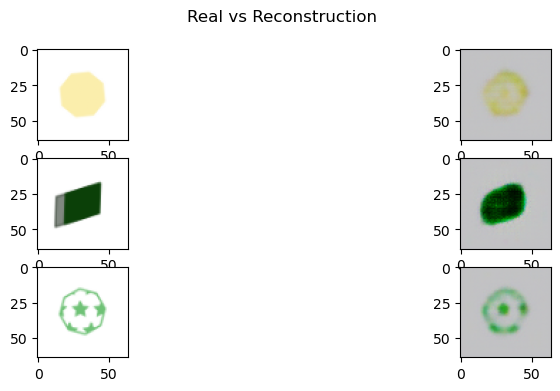

Epoch 3 | train loss 4565.83 | valid loss 4124.49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:54<00:00,  5.15it/s]
Epoch 4:   0%|▋                                                                                                                                                                                         | 1/282 [00:00<01:16,  3.67it/s]

tensor(2.0644, grad_fn=<MseLossBackward0>)
tensor(4.1199, grad_fn=<MseLossBackward0>)


Epoch 4:   1%|█▉                                                                                                                                                                                        | 3/282 [00:00<00:54,  5.11it/s]

tensor(4.3656, grad_fn=<MseLossBackward0>)
tensor(3.4026, grad_fn=<MseLossBackward0>)


Epoch 4:   2%|███▎                                                                                                                                                                                      | 5/282 [00:00<00:50,  5.51it/s]

tensor(2.3965, grad_fn=<MseLossBackward0>)
tensor(4.5415, grad_fn=<MseLossBackward0>)


Epoch 4:   2%|████▌                                                                                                                                                                                     | 7/282 [00:01<00:50,  5.46it/s]

tensor(2.7942, grad_fn=<MseLossBackward0>)
tensor(2.6794, grad_fn=<MseLossBackward0>)


Epoch 4:   3%|█████▉                                                                                                                                                                                    | 9/282 [00:01<00:47,  5.73it/s]

tensor(4.1321, grad_fn=<MseLossBackward0>)
tensor(3.1943, grad_fn=<MseLossBackward0>)


Epoch 4:   4%|███████▏                                                                                                                                                                                 | 11/282 [00:02<00:48,  5.64it/s]

tensor(2.2255, grad_fn=<MseLossBackward0>)
tensor(3.4826, grad_fn=<MseLossBackward0>)


Epoch 4:   5%|████████▌                                                                                                                                                                                | 13/282 [00:02<00:47,  5.69it/s]

tensor(2.7291, grad_fn=<MseLossBackward0>)
tensor(2.4781, grad_fn=<MseLossBackward0>)


Epoch 4:   5%|█████████▊                                                                                                                                                                               | 15/282 [00:02<00:46,  5.72it/s]

tensor(2.3030, grad_fn=<MseLossBackward0>)
tensor(3.4428, grad_fn=<MseLossBackward0>)


Epoch 4:   6%|███████████▏                                                                                                                                                                             | 17/282 [00:03<00:46,  5.66it/s]

tensor(2.9562, grad_fn=<MseLossBackward0>)
tensor(2.3173, grad_fn=<MseLossBackward0>)


Epoch 4:   7%|████████████▍                                                                                                                                                                            | 19/282 [00:03<00:46,  5.62it/s]

tensor(2.9665, grad_fn=<MseLossBackward0>)
tensor(3.5322, grad_fn=<MseLossBackward0>)


Epoch 4:   7%|█████████████▊                                                                                                                                                                           | 21/282 [00:03<00:47,  5.50it/s]

tensor(3.9453, grad_fn=<MseLossBackward0>)
tensor(2.8697, grad_fn=<MseLossBackward0>)


Epoch 4:   8%|███████████████                                                                                                                                                                          | 23/282 [00:04<00:46,  5.54it/s]

tensor(4.6306, grad_fn=<MseLossBackward0>)
tensor(3.0360, grad_fn=<MseLossBackward0>)


Epoch 4:   9%|████████████████▍                                                                                                                                                                        | 25/282 [00:04<00:46,  5.55it/s]

tensor(3.3555, grad_fn=<MseLossBackward0>)
tensor(3.6687, grad_fn=<MseLossBackward0>)


Epoch 4:  10%|█████████████████▋                                                                                                                                                                       | 27/282 [00:04<00:46,  5.54it/s]

tensor(3.8821, grad_fn=<MseLossBackward0>)
tensor(3.2731, grad_fn=<MseLossBackward0>)


Epoch 4:  10%|███████████████████                                                                                                                                                                      | 29/282 [00:05<00:48,  5.23it/s]

tensor(3.6300, grad_fn=<MseLossBackward0>)


Epoch 4:  11%|███████████████████▋                                                                                                                                                                     | 30/282 [00:05<00:47,  5.32it/s]

tensor(2.6683, grad_fn=<MseLossBackward0>)
tensor(3.3475, grad_fn=<MseLossBackward0>)


Epoch 4:  11%|████████████████████▉                                                                                                                                                                    | 32/282 [00:05<00:46,  5.39it/s]

tensor(2.6178, grad_fn=<MseLossBackward0>)
tensor(3.9599, grad_fn=<MseLossBackward0>)


Epoch 4:  12%|██████████████████████▎                                                                                                                                                                  | 34/282 [00:06<00:43,  5.65it/s]

tensor(5.4575, grad_fn=<MseLossBackward0>)
tensor(3.2065, grad_fn=<MseLossBackward0>)


Epoch 4:  13%|███████████████████████▌                                                                                                                                                                 | 36/282 [00:06<00:44,  5.56it/s]

tensor(3.1616, grad_fn=<MseLossBackward0>)
tensor(2.9613, grad_fn=<MseLossBackward0>)


Epoch 4:  13%|████████████████████████▉                                                                                                                                                                | 38/282 [00:06<00:44,  5.52it/s]

tensor(3.8852, grad_fn=<MseLossBackward0>)
tensor(4.9028, grad_fn=<MseLossBackward0>)


Epoch 4:  14%|██████████████████████████▏                                                                                                                                                              | 40/282 [00:07<00:43,  5.53it/s]

tensor(3.1006, grad_fn=<MseLossBackward0>)
tensor(3.0451, grad_fn=<MseLossBackward0>)


Epoch 4:  15%|███████████████████████████▌                                                                                                                                                             | 42/282 [00:07<00:44,  5.44it/s]

tensor(3.2507, grad_fn=<MseLossBackward0>)
tensor(3.0870, grad_fn=<MseLossBackward0>)


Epoch 4:  16%|████████████████████████████▊                                                                                                                                                            | 44/282 [00:08<00:43,  5.46it/s]

tensor(3.8864, grad_fn=<MseLossBackward0>)
tensor(2.9205, grad_fn=<MseLossBackward0>)


Epoch 4:  16%|██████████████████████████████▏                                                                                                                                                          | 46/282 [00:08<00:42,  5.57it/s]

tensor(3.7087, grad_fn=<MseLossBackward0>)
tensor(2.3924, grad_fn=<MseLossBackward0>)


Epoch 4:  17%|███████████████████████████████▍                                                                                                                                                         | 48/282 [00:08<00:42,  5.46it/s]

tensor(3.1310, grad_fn=<MseLossBackward0>)
tensor(4.1288, grad_fn=<MseLossBackward0>)


Epoch 4:  18%|████████████████████████████████▊                                                                                                                                                        | 50/282 [00:09<00:41,  5.64it/s]

tensor(2.7921, grad_fn=<MseLossBackward0>)
tensor(3.4974, grad_fn=<MseLossBackward0>)


Epoch 4:  18%|██████████████████████████████████                                                                                                                                                       | 52/282 [00:09<00:40,  5.62it/s]

tensor(3.3794, grad_fn=<MseLossBackward0>)
tensor(2.6515, grad_fn=<MseLossBackward0>)


Epoch 4:  19%|███████████████████████████████████▍                                                                                                                                                     | 54/282 [00:09<00:40,  5.60it/s]

tensor(3.0492, grad_fn=<MseLossBackward0>)
tensor(2.3325, grad_fn=<MseLossBackward0>)


Epoch 4:  20%|████████████████████████████████████▋                                                                                                                                                    | 56/282 [00:10<00:40,  5.53it/s]

tensor(2.5024, grad_fn=<MseLossBackward0>)
tensor(2.7548, grad_fn=<MseLossBackward0>)


Epoch 4:  21%|██████████████████████████████████████                                                                                                                                                   | 58/282 [00:10<00:41,  5.43it/s]

tensor(3.1977, grad_fn=<MseLossBackward0>)
tensor(4.0634, grad_fn=<MseLossBackward0>)


Epoch 4:  21%|███████████████████████████████████████▎                                                                                                                                                 | 60/282 [00:10<00:40,  5.49it/s]

tensor(2.3813, grad_fn=<MseLossBackward0>)
tensor(2.5574, grad_fn=<MseLossBackward0>)


Epoch 4:  22%|████████████████████████████████████████▋                                                                                                                                                | 62/282 [00:11<00:40,  5.44it/s]

tensor(3.7222, grad_fn=<MseLossBackward0>)
tensor(2.8283, grad_fn=<MseLossBackward0>)


Epoch 4:  23%|█████████████████████████████████████████▉                                                                                                                                               | 64/282 [00:11<00:39,  5.48it/s]

tensor(2.3074, grad_fn=<MseLossBackward0>)
tensor(4.0442, grad_fn=<MseLossBackward0>)


Epoch 4:  23%|███████████████████████████████████████████▎                                                                                                                                             | 66/282 [00:12<00:40,  5.37it/s]

tensor(2.6657, grad_fn=<MseLossBackward0>)
tensor(4.0350, grad_fn=<MseLossBackward0>)


Epoch 4:  24%|████████████████████████████████████████████▌                                                                                                                                            | 68/282 [00:12<00:39,  5.45it/s]

tensor(3.8113, grad_fn=<MseLossBackward0>)
tensor(4.4620, grad_fn=<MseLossBackward0>)


Epoch 4:  25%|█████████████████████████████████████████████▉                                                                                                                                           | 70/282 [00:12<00:38,  5.45it/s]

tensor(5.3197, grad_fn=<MseLossBackward0>)
tensor(3.4025, grad_fn=<MseLossBackward0>)


Epoch 4:  26%|███████████████████████████████████████████████▏                                                                                                                                         | 72/282 [00:13<00:37,  5.60it/s]

tensor(3.5829, grad_fn=<MseLossBackward0>)
tensor(3.5971, grad_fn=<MseLossBackward0>)


Epoch 4:  26%|████████████████████████████████████████████████▌                                                                                                                                        | 74/282 [00:13<00:37,  5.58it/s]

tensor(2.7513, grad_fn=<MseLossBackward0>)
tensor(5.1049, grad_fn=<MseLossBackward0>)


Epoch 4:  27%|█████████████████████████████████████████████████▊                                                                                                                                       | 76/282 [00:13<00:37,  5.55it/s]

tensor(4.9899, grad_fn=<MseLossBackward0>)
tensor(5.2623, grad_fn=<MseLossBackward0>)


Epoch 4:  28%|███████████████████████████████████████████████████▏                                                                                                                                     | 78/282 [00:14<00:36,  5.58it/s]

tensor(4.4308, grad_fn=<MseLossBackward0>)
tensor(3.1201, grad_fn=<MseLossBackward0>)


Epoch 4:  28%|████████████████████████████████████████████████████▍                                                                                                                                    | 80/282 [00:14<00:35,  5.64it/s]

tensor(3.1269, grad_fn=<MseLossBackward0>)
tensor(2.7336, grad_fn=<MseLossBackward0>)


Epoch 4:  29%|█████████████████████████████████████████████████████▊                                                                                                                                   | 82/282 [00:14<00:34,  5.74it/s]

tensor(4.5370, grad_fn=<MseLossBackward0>)
tensor(2.9326, grad_fn=<MseLossBackward0>)


Epoch 4:  30%|███████████████████████████████████████████████████████                                                                                                                                  | 84/282 [00:15<00:35,  5.58it/s]

tensor(2.2761, grad_fn=<MseLossBackward0>)
tensor(2.3895, grad_fn=<MseLossBackward0>)


Epoch 4:  30%|████████████████████████████████████████████████████████▍                                                                                                                                | 86/282 [00:15<00:33,  5.77it/s]

tensor(3.6556, grad_fn=<MseLossBackward0>)
tensor(3.7436, grad_fn=<MseLossBackward0>)


Epoch 4:  31%|█████████████████████████████████████████████████████████▋                                                                                                                               | 88/282 [00:15<00:33,  5.79it/s]

tensor(3.5193, grad_fn=<MseLossBackward0>)
tensor(4.6545, grad_fn=<MseLossBackward0>)


Epoch 4:  32%|███████████████████████████████████████████████████████████                                                                                                                              | 90/282 [00:16<00:34,  5.63it/s]

tensor(4.8671, grad_fn=<MseLossBackward0>)
tensor(2.7162, grad_fn=<MseLossBackward0>)


Epoch 4:  33%|████████████████████████████████████████████████████████████▎                                                                                                                            | 92/282 [00:16<00:34,  5.53it/s]

tensor(2.4718, grad_fn=<MseLossBackward0>)
tensor(3.9436, grad_fn=<MseLossBackward0>)


Epoch 4:  33%|█████████████████████████████████████████████████████████████▋                                                                                                                           | 94/282 [00:17<00:34,  5.47it/s]

tensor(2.4740, grad_fn=<MseLossBackward0>)
tensor(4.1408, grad_fn=<MseLossBackward0>)


Epoch 4:  34%|██████████████████████████████████████████████████████████████▉                                                                                                                          | 96/282 [00:17<00:33,  5.50it/s]

tensor(3.9947, grad_fn=<MseLossBackward0>)


Epoch 4:  34%|███████████████████████████████████████████████████████████████▋                                                                                                                         | 97/282 [00:17<00:34,  5.31it/s]

tensor(5.0030, grad_fn=<MseLossBackward0>)
tensor(3.2196, grad_fn=<MseLossBackward0>)


Epoch 4:  35%|████████████████████████████████████████████████████████████████▉                                                                                                                        | 99/282 [00:17<00:33,  5.49it/s]

tensor(2.7105, grad_fn=<MseLossBackward0>)
tensor(2.8906, grad_fn=<MseLossBackward0>)


Epoch 4:  36%|█████████████████████████████████████████████████████████████████▉                                                                                                                      | 101/282 [00:18<00:37,  4.77it/s]

tensor(3.9519, grad_fn=<MseLossBackward0>)


Epoch 4:  36%|██████████████████████████████████████████████████████████████████▌                                                                                                                     | 102/282 [00:18<00:36,  4.96it/s]

tensor(2.5344, grad_fn=<MseLossBackward0>)
tensor(3.2849, grad_fn=<MseLossBackward0>)


Epoch 4:  37%|███████████████████████████████████████████████████████████████████▊                                                                                                                    | 104/282 [00:18<00:33,  5.30it/s]

tensor(3.6253, grad_fn=<MseLossBackward0>)
tensor(4.9606, grad_fn=<MseLossBackward0>)


Epoch 4:  38%|█████████████████████████████████████████████████████████████████████▏                                                                                                                  | 106/282 [00:19<00:32,  5.48it/s]

tensor(3.2802, grad_fn=<MseLossBackward0>)
tensor(2.3369, grad_fn=<MseLossBackward0>)


Epoch 4:  38%|██████████████████████████████████████████████████████████████████████▍                                                                                                                 | 108/282 [00:19<00:31,  5.59it/s]

tensor(2.4092, grad_fn=<MseLossBackward0>)
tensor(3.2547, grad_fn=<MseLossBackward0>)


Epoch 4:  39%|███████████████████████████████████████████████████████████████████████▊                                                                                                                | 110/282 [00:20<00:31,  5.49it/s]

tensor(2.9459, grad_fn=<MseLossBackward0>)
tensor(3.0673, grad_fn=<MseLossBackward0>)


Epoch 4:  40%|█████████████████████████████████████████████████████████████████████████                                                                                                               | 112/282 [00:20<00:30,  5.58it/s]

tensor(3.7737, grad_fn=<MseLossBackward0>)
tensor(4.1341, grad_fn=<MseLossBackward0>)


Epoch 4:  40%|██████████████████████████████████████████████████████████████████████████▍                                                                                                             | 114/282 [00:20<00:30,  5.47it/s]

tensor(2.3968, grad_fn=<MseLossBackward0>)
tensor(2.9374, grad_fn=<MseLossBackward0>)


Epoch 4:  41%|███████████████████████████████████████████████████████████████████████████▋                                                                                                            | 116/282 [00:21<00:30,  5.52it/s]

tensor(2.3675, grad_fn=<MseLossBackward0>)
tensor(3.2657, grad_fn=<MseLossBackward0>)


Epoch 4:  42%|████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 118/282 [00:21<00:29,  5.61it/s]

tensor(2.5234, grad_fn=<MseLossBackward0>)
tensor(2.0931, grad_fn=<MseLossBackward0>)


Epoch 4:  43%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 120/282 [00:21<00:30,  5.39it/s]

tensor(3.8286, grad_fn=<MseLossBackward0>)
tensor(3.8106, grad_fn=<MseLossBackward0>)


Epoch 4:  43%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 122/282 [00:22<00:29,  5.51it/s]

tensor(3.7164, grad_fn=<MseLossBackward0>)
tensor(3.0256, grad_fn=<MseLossBackward0>)


Epoch 4:  44%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 124/282 [00:22<00:29,  5.42it/s]

tensor(3.1736, grad_fn=<MseLossBackward0>)
tensor(2.7488, grad_fn=<MseLossBackward0>)


Epoch 4:  45%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 126/282 [00:22<00:28,  5.41it/s]

tensor(3.4030, grad_fn=<MseLossBackward0>)
tensor(3.6936, grad_fn=<MseLossBackward0>)


Epoch 4:  45%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 128/282 [00:23<00:27,  5.55it/s]

tensor(2.8472, grad_fn=<MseLossBackward0>)
tensor(3.3748, grad_fn=<MseLossBackward0>)


Epoch 4:  46%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 130/282 [00:23<00:27,  5.47it/s]

tensor(2.7138, grad_fn=<MseLossBackward0>)
tensor(3.1204, grad_fn=<MseLossBackward0>)


Epoch 4:  47%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 132/282 [00:24<00:27,  5.44it/s]

tensor(2.3055, grad_fn=<MseLossBackward0>)
tensor(3.6225, grad_fn=<MseLossBackward0>)


Epoch 4:  48%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 134/282 [00:24<00:26,  5.54it/s]

tensor(1.8908, grad_fn=<MseLossBackward0>)
tensor(2.6496, grad_fn=<MseLossBackward0>)


Epoch 4:  48%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 136/282 [00:24<00:26,  5.47it/s]

tensor(2.4351, grad_fn=<MseLossBackward0>)
tensor(3.7568, grad_fn=<MseLossBackward0>)


Epoch 4:  49%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 138/282 [00:25<00:26,  5.50it/s]

tensor(3.8748, grad_fn=<MseLossBackward0>)
tensor(4.1735, grad_fn=<MseLossBackward0>)


Epoch 4:  50%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 140/282 [00:25<00:25,  5.54it/s]

tensor(3.1895, grad_fn=<MseLossBackward0>)
tensor(3.9884, grad_fn=<MseLossBackward0>)


Epoch 4:  50%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 142/282 [00:25<00:25,  5.39it/s]

tensor(3.5507, grad_fn=<MseLossBackward0>)
tensor(3.3020, grad_fn=<MseLossBackward0>)


Epoch 4:  51%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 144/282 [00:26<00:24,  5.53it/s]

tensor(3.2021, grad_fn=<MseLossBackward0>)
tensor(2.4336, grad_fn=<MseLossBackward0>)


Epoch 4:  52%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 146/282 [00:26<00:24,  5.48it/s]

tensor(3.9017, grad_fn=<MseLossBackward0>)
tensor(4.1963, grad_fn=<MseLossBackward0>)


Epoch 4:  52%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 148/282 [00:26<00:23,  5.67it/s]

tensor(4.0942, grad_fn=<MseLossBackward0>)
tensor(3.6776, grad_fn=<MseLossBackward0>)


Epoch 4:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 150/282 [00:27<00:23,  5.56it/s]

tensor(3.0504, grad_fn=<MseLossBackward0>)
tensor(3.8827, grad_fn=<MseLossBackward0>)


Epoch 4:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 152/282 [00:27<00:23,  5.52it/s]

tensor(2.7307, grad_fn=<MseLossBackward0>)
tensor(4.2480, grad_fn=<MseLossBackward0>)


Epoch 4:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 154/282 [00:28<00:23,  5.42it/s]

tensor(3.0227, grad_fn=<MseLossBackward0>)
tensor(2.7222, grad_fn=<MseLossBackward0>)


Epoch 4:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 156/282 [00:28<00:23,  5.42it/s]

tensor(3.2490, grad_fn=<MseLossBackward0>)
tensor(2.5495, grad_fn=<MseLossBackward0>)


Epoch 4:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 158/282 [00:28<00:22,  5.58it/s]

tensor(2.7083, grad_fn=<MseLossBackward0>)
tensor(3.1133, grad_fn=<MseLossBackward0>)


Epoch 4:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 160/282 [00:29<00:22,  5.43it/s]

tensor(3.5991, grad_fn=<MseLossBackward0>)
tensor(3.2691, grad_fn=<MseLossBackward0>)


Epoch 4:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 162/282 [00:29<00:22,  5.41it/s]

tensor(3.2919, grad_fn=<MseLossBackward0>)
tensor(2.9486, grad_fn=<MseLossBackward0>)


Epoch 4:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 164/282 [00:29<00:22,  5.35it/s]

tensor(3.6051, grad_fn=<MseLossBackward0>)
tensor(3.5617, grad_fn=<MseLossBackward0>)


Epoch 4:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 166/282 [00:30<00:21,  5.49it/s]

tensor(2.6566, grad_fn=<MseLossBackward0>)
tensor(3.4487, grad_fn=<MseLossBackward0>)


Epoch 4:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 168/282 [00:30<00:21,  5.41it/s]

tensor(5.0307, grad_fn=<MseLossBackward0>)
tensor(2.8226, grad_fn=<MseLossBackward0>)


Epoch 4:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 170/282 [00:30<00:20,  5.56it/s]

tensor(3.9791, grad_fn=<MseLossBackward0>)
tensor(2.7153, grad_fn=<MseLossBackward0>)


Epoch 4:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 172/282 [00:31<00:20,  5.47it/s]

tensor(2.3039, grad_fn=<MseLossBackward0>)
tensor(3.8183, grad_fn=<MseLossBackward0>)


Epoch 4:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 174/282 [00:31<00:19,  5.58it/s]

tensor(2.2933, grad_fn=<MseLossBackward0>)
tensor(4.0068, grad_fn=<MseLossBackward0>)


Epoch 4:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 176/282 [00:32<00:18,  5.70it/s]

tensor(2.5947, grad_fn=<MseLossBackward0>)
tensor(2.7091, grad_fn=<MseLossBackward0>)


Epoch 4:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 178/282 [00:32<00:18,  5.56it/s]

tensor(2.7406, grad_fn=<MseLossBackward0>)
tensor(2.2827, grad_fn=<MseLossBackward0>)


Epoch 4:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 180/282 [00:32<00:18,  5.48it/s]

tensor(3.1074, grad_fn=<MseLossBackward0>)
tensor(3.5961, grad_fn=<MseLossBackward0>)


Epoch 4:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 182/282 [00:33<00:17,  5.67it/s]

tensor(4.1190, grad_fn=<MseLossBackward0>)
tensor(2.1924, grad_fn=<MseLossBackward0>)


Epoch 4:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 184/282 [00:33<00:17,  5.62it/s]

tensor(2.5272, grad_fn=<MseLossBackward0>)
tensor(2.3109, grad_fn=<MseLossBackward0>)


Epoch 4:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 186/282 [00:33<00:17,  5.58it/s]

tensor(2.6188, grad_fn=<MseLossBackward0>)
tensor(3.6042, grad_fn=<MseLossBackward0>)


Epoch 4:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 188/282 [00:34<00:16,  5.57it/s]

tensor(2.4846, grad_fn=<MseLossBackward0>)
tensor(2.6438, grad_fn=<MseLossBackward0>)


Epoch 4:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 190/282 [00:34<00:16,  5.69it/s]

tensor(2.4338, grad_fn=<MseLossBackward0>)


Epoch 4:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 191/282 [00:34<00:18,  4.99it/s]

tensor(3.1828, grad_fn=<MseLossBackward0>)
tensor(2.9520, grad_fn=<MseLossBackward0>)


Epoch 4:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 193/282 [00:35<00:16,  5.25it/s]

tensor(3.2980, grad_fn=<MseLossBackward0>)
tensor(3.2143, grad_fn=<MseLossBackward0>)


Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 195/282 [00:35<00:17,  4.99it/s]

tensor(2.4339, grad_fn=<MseLossBackward0>)
tensor(2.5305, grad_fn=<MseLossBackward0>)


Epoch 4:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 197/282 [00:35<00:16,  5.28it/s]

tensor(3.4673, grad_fn=<MseLossBackward0>)


Epoch 4:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 198/282 [00:36<00:17,  4.80it/s]

tensor(4.5320, grad_fn=<MseLossBackward0>)
tensor(3.2660, grad_fn=<MseLossBackward0>)


Epoch 4:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 200/282 [00:36<00:16,  5.10it/s]

tensor(2.9311, grad_fn=<MseLossBackward0>)
tensor(2.8815, grad_fn=<MseLossBackward0>)


Epoch 4:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 202/282 [00:36<00:15,  5.27it/s]

tensor(3.7669, grad_fn=<MseLossBackward0>)
tensor(4.0110, grad_fn=<MseLossBackward0>)


Epoch 4:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 204/282 [00:37<00:14,  5.56it/s]

tensor(2.7706, grad_fn=<MseLossBackward0>)
tensor(5.4513, grad_fn=<MseLossBackward0>)


Epoch 4:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 206/282 [00:37<00:13,  5.65it/s]

tensor(5.0798, grad_fn=<MseLossBackward0>)
tensor(3.2627, grad_fn=<MseLossBackward0>)


Epoch 4:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 208/282 [00:37<00:13,  5.53it/s]

tensor(3.3864, grad_fn=<MseLossBackward0>)
tensor(4.0724, grad_fn=<MseLossBackward0>)


Epoch 4:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 210/282 [00:38<00:13,  5.44it/s]

tensor(3.5681, grad_fn=<MseLossBackward0>)
tensor(3.7643, grad_fn=<MseLossBackward0>)


Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 212/282 [00:38<00:13,  5.38it/s]

tensor(3.8066, grad_fn=<MseLossBackward0>)
tensor(3.0288, grad_fn=<MseLossBackward0>)


Epoch 4:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 214/282 [00:39<00:12,  5.59it/s]

tensor(3.0471, grad_fn=<MseLossBackward0>)
tensor(2.9987, grad_fn=<MseLossBackward0>)


Epoch 4:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 216/282 [00:39<00:12,  5.47it/s]

tensor(2.4278, grad_fn=<MseLossBackward0>)
tensor(2.4831, grad_fn=<MseLossBackward0>)


Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 218/282 [00:39<00:11,  5.42it/s]

tensor(3.0977, grad_fn=<MseLossBackward0>)
tensor(2.9244, grad_fn=<MseLossBackward0>)


Epoch 4:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 220/282 [00:40<00:11,  5.50it/s]

tensor(3.2564, grad_fn=<MseLossBackward0>)
tensor(3.5102, grad_fn=<MseLossBackward0>)


Epoch 4:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 222/282 [00:40<00:11,  5.41it/s]

tensor(2.6975, grad_fn=<MseLossBackward0>)
tensor(4.3962, grad_fn=<MseLossBackward0>)


Epoch 4:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 224/282 [00:40<00:10,  5.36it/s]

tensor(4.8572, grad_fn=<MseLossBackward0>)
tensor(2.8536, grad_fn=<MseLossBackward0>)


Epoch 4:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 226/282 [00:41<00:10,  5.38it/s]

tensor(2.5242, grad_fn=<MseLossBackward0>)
tensor(2.9758, grad_fn=<MseLossBackward0>)


Epoch 4:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 228/282 [00:41<00:09,  5.51it/s]

tensor(3.2248, grad_fn=<MseLossBackward0>)
tensor(3.2085, grad_fn=<MseLossBackward0>)


Epoch 4:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 230/282 [00:42<00:09,  5.44it/s]

tensor(3.6954, grad_fn=<MseLossBackward0>)
tensor(3.7009, grad_fn=<MseLossBackward0>)


Epoch 4:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 232/282 [00:42<00:09,  5.34it/s]

tensor(3.0763, grad_fn=<MseLossBackward0>)
tensor(2.3901, grad_fn=<MseLossBackward0>)


Epoch 4:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 234/282 [00:42<00:09,  5.28it/s]

tensor(3.7615, grad_fn=<MseLossBackward0>)
tensor(2.3763, grad_fn=<MseLossBackward0>)


Epoch 4:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 236/282 [00:43<00:08,  5.30it/s]

tensor(3.7610, grad_fn=<MseLossBackward0>)
tensor(2.3427, grad_fn=<MseLossBackward0>)


Epoch 4:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 238/282 [00:43<00:08,  5.39it/s]

tensor(2.0788, grad_fn=<MseLossBackward0>)
tensor(3.1562, grad_fn=<MseLossBackward0>)


Epoch 4:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 240/282 [00:43<00:07,  5.43it/s]

tensor(3.7784, grad_fn=<MseLossBackward0>)
tensor(3.4276, grad_fn=<MseLossBackward0>)


Epoch 4:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 242/282 [00:44<00:07,  5.20it/s]

tensor(3.2010, grad_fn=<MseLossBackward0>)


Epoch 4:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 243/282 [00:44<00:07,  5.13it/s]

tensor(3.5147, grad_fn=<MseLossBackward0>)


Epoch 4:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 244/282 [00:44<00:07,  5.09it/s]

tensor(4.6524, grad_fn=<MseLossBackward0>)
tensor(3.1396, grad_fn=<MseLossBackward0>)


Epoch 4:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 246/282 [00:45<00:06,  5.27it/s]

tensor(3.4094, grad_fn=<MseLossBackward0>)
tensor(2.3791, grad_fn=<MseLossBackward0>)


Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 248/282 [00:45<00:06,  5.38it/s]

tensor(2.9114, grad_fn=<MseLossBackward0>)
tensor(4.7271, grad_fn=<MseLossBackward0>)


Epoch 4:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 250/282 [00:45<00:05,  5.43it/s]

tensor(3.2191, grad_fn=<MseLossBackward0>)
tensor(2.9333, grad_fn=<MseLossBackward0>)


Epoch 4:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 252/282 [00:46<00:05,  5.15it/s]

tensor(3.7086, grad_fn=<MseLossBackward0>)
tensor(3.3039, grad_fn=<MseLossBackward0>)


Epoch 4:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 254/282 [00:46<00:05,  5.22it/s]

tensor(2.5098, grad_fn=<MseLossBackward0>)
tensor(2.0367, grad_fn=<MseLossBackward0>)


Epoch 4:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 256/282 [00:46<00:04,  5.27it/s]

tensor(2.8534, grad_fn=<MseLossBackward0>)
tensor(3.2979, grad_fn=<MseLossBackward0>)


Epoch 4:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 258/282 [00:47<00:04,  5.50it/s]

tensor(3.1095, grad_fn=<MseLossBackward0>)
tensor(3.9318, grad_fn=<MseLossBackward0>)


Epoch 4:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 260/282 [00:47<00:04,  5.49it/s]

tensor(2.8147, grad_fn=<MseLossBackward0>)
tensor(2.6996, grad_fn=<MseLossBackward0>)


Epoch 4:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 262/282 [00:48<00:03,  5.38it/s]

tensor(3.5050, grad_fn=<MseLossBackward0>)
tensor(3.2280, grad_fn=<MseLossBackward0>)


Epoch 4:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 264/282 [00:48<00:03,  5.42it/s]

tensor(2.6097, grad_fn=<MseLossBackward0>)
tensor(3.3962, grad_fn=<MseLossBackward0>)


Epoch 4:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 266/282 [00:48<00:02,  5.61it/s]

tensor(2.7314, grad_fn=<MseLossBackward0>)
tensor(2.7362, grad_fn=<MseLossBackward0>)


Epoch 4:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 268/282 [00:49<00:02,  5.38it/s]

tensor(2.8125, grad_fn=<MseLossBackward0>)
tensor(2.7106, grad_fn=<MseLossBackward0>)


Epoch 4:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 270/282 [00:49<00:02,  5.11it/s]

tensor(3.2711, grad_fn=<MseLossBackward0>)
tensor(3.2022, grad_fn=<MseLossBackward0>)


Epoch 4:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 272/282 [00:49<00:01,  5.37it/s]

tensor(4.2126, grad_fn=<MseLossBackward0>)
tensor(4.5810, grad_fn=<MseLossBackward0>)


Epoch 4:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 274/282 [00:50<00:01,  5.56it/s]

tensor(3.2667, grad_fn=<MseLossBackward0>)
tensor(3.0811, grad_fn=<MseLossBackward0>)


Epoch 4:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 276/282 [00:50<00:01,  5.55it/s]

tensor(3.0488, grad_fn=<MseLossBackward0>)
tensor(3.0549, grad_fn=<MseLossBackward0>)


Epoch 4:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 278/282 [00:51<00:00,  5.58it/s]

tensor(2.2400, grad_fn=<MseLossBackward0>)
tensor(3.3247, grad_fn=<MseLossBackward0>)


Epoch 4:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 280/282 [00:51<00:00,  5.43it/s]

tensor(3.1360, grad_fn=<MseLossBackward0>)
tensor(2.5665, grad_fn=<MseLossBackward0>)


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:51<00:00,  5.48it/s]

tensor(0.6047, grad_fn=<MseLossBackward0>)
tensor(2.3996)
tensor(2.7963)
tensor(2.4412)
tensor(2.8644)
tensor(3.6068)
tensor(2.3213)
tensor(2.8404)
tensor(2.6430)
tensor(2.7579)
tensor(2.5224)
tensor(3.4289)
tensor(2.6901)
tensor(3.0264)
tensor(3.1102)
tensor(3.0148)
tensor(3.0394)
tensor(2.0613)
tensor(2.1630)
tensor(1.9154)
tensor(2.3374)
tensor(2.7165)
tensor(3.0077)
tensor(2.9582)
tensor(2.8259)
tensor(2.2608)
tensor(2.3359)
tensor(2.6915)
tensor(3.9093)
tensor(3.0279)
tensor(2.8094)
tensor(3.3459)
tensor(0.9307)


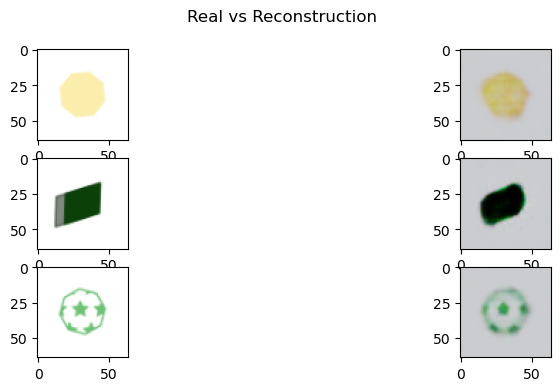

Epoch 4 | train loss 3871.57 | valid loss 3544.62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:54<00:00,  5.17it/s]
Epoch 5:   0%|▋                                                                                                                                                                                         | 1/282 [00:00<01:14,  3.79it/s]

tensor(2.4313, grad_fn=<MseLossBackward0>)
tensor(3.0763, grad_fn=<MseLossBackward0>)


Epoch 5:   1%|█▉                                                                                                                                                                                        | 3/282 [00:00<00:56,  4.90it/s]

tensor(3.3581, grad_fn=<MseLossBackward0>)
tensor(2.6641, grad_fn=<MseLossBackward0>)


Epoch 5:   2%|███▎                                                                                                                                                                                      | 5/282 [00:01<00:52,  5.25it/s]

tensor(3.3454, grad_fn=<MseLossBackward0>)
tensor(3.8233, grad_fn=<MseLossBackward0>)


Epoch 5:   2%|████▌                                                                                                                                                                                     | 7/282 [00:01<00:51,  5.34it/s]

tensor(2.6835, grad_fn=<MseLossBackward0>)
tensor(4.3362, grad_fn=<MseLossBackward0>)


Epoch 5:   3%|█████▉                                                                                                                                                                                    | 9/282 [00:01<00:51,  5.29it/s]

tensor(2.8164, grad_fn=<MseLossBackward0>)
tensor(3.0414, grad_fn=<MseLossBackward0>)


Epoch 5:   4%|███████▏                                                                                                                                                                                 | 11/282 [00:02<00:49,  5.51it/s]

tensor(3.0844, grad_fn=<MseLossBackward0>)
tensor(2.9086, grad_fn=<MseLossBackward0>)


Epoch 5:   5%|████████▌                                                                                                                                                                                | 13/282 [00:02<00:48,  5.52it/s]

tensor(2.9631, grad_fn=<MseLossBackward0>)
tensor(4.0654, grad_fn=<MseLossBackward0>)


Epoch 5:   5%|█████████▊                                                                                                                                                                               | 15/282 [00:02<00:47,  5.57it/s]

tensor(2.7623, grad_fn=<MseLossBackward0>)
tensor(4.9627, grad_fn=<MseLossBackward0>)


Epoch 5:   6%|███████████▏                                                                                                                                                                             | 17/282 [00:03<00:51,  5.11it/s]

tensor(5.0742, grad_fn=<MseLossBackward0>)
tensor(2.3089, grad_fn=<MseLossBackward0>)


Epoch 5:   7%|████████████▍                                                                                                                                                                            | 19/282 [00:03<00:52,  4.97it/s]

tensor(3.9902, grad_fn=<MseLossBackward0>)


Epoch 5:   7%|█████████████                                                                                                                                                                            | 20/282 [00:03<00:56,  4.61it/s]

tensor(3.0805, grad_fn=<MseLossBackward0>)


Epoch 5:   7%|█████████████▊                                                                                                                                                                           | 21/282 [00:04<01:02,  4.19it/s]

tensor(3.5197, grad_fn=<MseLossBackward0>)


Epoch 5:   8%|██████████████▍                                                                                                                                                                          | 22/282 [00:04<00:59,  4.33it/s]

tensor(3.5632, grad_fn=<MseLossBackward0>)
tensor(2.7988, grad_fn=<MseLossBackward0>)


Epoch 5:   9%|███████████████▋                                                                                                                                                                         | 24/282 [00:04<00:54,  4.70it/s]

tensor(3.2289, grad_fn=<MseLossBackward0>)
tensor(2.7190, grad_fn=<MseLossBackward0>)


Epoch 5:   9%|█████████████████                                                                                                                                                                        | 26/282 [00:05<00:51,  4.95it/s]

tensor(2.2774, grad_fn=<MseLossBackward0>)
tensor(3.7547, grad_fn=<MseLossBackward0>)


Epoch 5:  10%|██████████████████▎                                                                                                                                                                      | 28/282 [00:05<00:51,  4.92it/s]

tensor(3.1500, grad_fn=<MseLossBackward0>)
tensor(3.0145, grad_fn=<MseLossBackward0>)


Epoch 5:  11%|███████████████████▋                                                                                                                                                                     | 30/282 [00:05<00:47,  5.27it/s]

tensor(2.6005, grad_fn=<MseLossBackward0>)
tensor(2.6160, grad_fn=<MseLossBackward0>)


Epoch 5:  11%|████████████████████▉                                                                                                                                                                    | 32/282 [00:06<00:48,  5.19it/s]

tensor(3.7140, grad_fn=<MseLossBackward0>)
tensor(2.5647, grad_fn=<MseLossBackward0>)


Epoch 5:  12%|██████████████████████▎                                                                                                                                                                  | 34/282 [00:06<00:46,  5.28it/s]

tensor(2.5704, grad_fn=<MseLossBackward0>)
tensor(3.0194, grad_fn=<MseLossBackward0>)


Epoch 5:  13%|███████████████████████▌                                                                                                                                                                 | 36/282 [00:07<00:47,  5.18it/s]

tensor(3.2849, grad_fn=<MseLossBackward0>)
tensor(2.7390, grad_fn=<MseLossBackward0>)


Epoch 5:  13%|████████████████████████▉                                                                                                                                                                | 38/282 [00:07<00:46,  5.24it/s]

tensor(2.7379, grad_fn=<MseLossBackward0>)
tensor(2.6406, grad_fn=<MseLossBackward0>)


Epoch 5:  14%|██████████████████████████▏                                                                                                                                                              | 40/282 [00:07<00:46,  5.23it/s]

tensor(3.3095, grad_fn=<MseLossBackward0>)
tensor(2.7630, grad_fn=<MseLossBackward0>)


Epoch 5:  15%|███████████████████████████▌                                                                                                                                                             | 42/282 [00:08<00:44,  5.35it/s]

tensor(2.7802, grad_fn=<MseLossBackward0>)
tensor(2.5752, grad_fn=<MseLossBackward0>)


Epoch 5:  16%|████████████████████████████▊                                                                                                                                                            | 44/282 [00:08<00:45,  5.24it/s]

tensor(3.4349, grad_fn=<MseLossBackward0>)
tensor(2.5199, grad_fn=<MseLossBackward0>)


Epoch 5:  16%|██████████████████████████████▏                                                                                                                                                          | 46/282 [00:09<00:44,  5.27it/s]

tensor(3.1186, grad_fn=<MseLossBackward0>)
tensor(3.2996, grad_fn=<MseLossBackward0>)


Epoch 5:  17%|███████████████████████████████▍                                                                                                                                                         | 48/282 [00:09<00:43,  5.44it/s]

tensor(3.0982, grad_fn=<MseLossBackward0>)
tensor(3.1903, grad_fn=<MseLossBackward0>)


Epoch 5:  18%|████████████████████████████████▊                                                                                                                                                        | 50/282 [00:09<00:43,  5.32it/s]

tensor(2.7158, grad_fn=<MseLossBackward0>)


Epoch 5:  18%|█████████████████████████████████▍                                                                                                                                                       | 51/282 [00:09<00:43,  5.29it/s]

tensor(2.7038, grad_fn=<MseLossBackward0>)
tensor(2.5957, grad_fn=<MseLossBackward0>)


Epoch 5:  19%|██████████████████████████████████▊                                                                                                                                                      | 53/282 [00:10<00:41,  5.46it/s]

tensor(4.2000, grad_fn=<MseLossBackward0>)
tensor(3.9912, grad_fn=<MseLossBackward0>)


Epoch 5:  20%|████████████████████████████████████                                                                                                                                                     | 55/282 [00:10<00:42,  5.34it/s]

tensor(3.2458, grad_fn=<MseLossBackward0>)
tensor(2.5461, grad_fn=<MseLossBackward0>)


Epoch 5:  20%|█████████████████████████████████████▍                                                                                                                                                   | 57/282 [00:11<00:42,  5.27it/s]

tensor(1.9915, grad_fn=<MseLossBackward0>)
tensor(2.5492, grad_fn=<MseLossBackward0>)


Epoch 5:  21%|██████████████████████████████████████▋                                                                                                                                                  | 59/282 [00:11<00:41,  5.39it/s]

tensor(2.5455, grad_fn=<MseLossBackward0>)
tensor(3.0745, grad_fn=<MseLossBackward0>)


Epoch 5:  22%|████████████████████████████████████████                                                                                                                                                 | 61/282 [00:11<00:40,  5.43it/s]

tensor(2.2170, grad_fn=<MseLossBackward0>)
tensor(3.3282, grad_fn=<MseLossBackward0>)


Epoch 5:  22%|█████████████████████████████████████████▎                                                                                                                                               | 63/282 [00:12<00:41,  5.26it/s]

tensor(5.2177, grad_fn=<MseLossBackward0>)
tensor(4.2450, grad_fn=<MseLossBackward0>)


Epoch 5:  23%|██████████████████████████████████████████▋                                                                                                                                              | 65/282 [00:12<00:41,  5.25it/s]

tensor(4.6312, grad_fn=<MseLossBackward0>)
tensor(3.7918, grad_fn=<MseLossBackward0>)


Epoch 5:  24%|███████████████████████████████████████████▉                                                                                                                                             | 67/282 [00:12<00:40,  5.31it/s]

tensor(4.3342, grad_fn=<MseLossBackward0>)
tensor(2.6659, grad_fn=<MseLossBackward0>)


Epoch 5:  24%|█████████████████████████████████████████████▎                                                                                                                                           | 69/282 [00:13<00:39,  5.42it/s]

tensor(2.9131, grad_fn=<MseLossBackward0>)
tensor(2.8984, grad_fn=<MseLossBackward0>)


Epoch 5:  25%|██████████████████████████████████████████████▌                                                                                                                                          | 71/282 [00:13<00:38,  5.46it/s]

tensor(3.5417, grad_fn=<MseLossBackward0>)
tensor(3.1562, grad_fn=<MseLossBackward0>)


Epoch 5:  26%|███████████████████████████████████████████████▉                                                                                                                                         | 73/282 [00:14<00:39,  5.35it/s]

tensor(3.1889, grad_fn=<MseLossBackward0>)
tensor(2.8661, grad_fn=<MseLossBackward0>)


Epoch 5:  27%|█████████████████████████████████████████████████▏                                                                                                                                       | 75/282 [00:14<00:38,  5.41it/s]

tensor(3.1505, grad_fn=<MseLossBackward0>)
tensor(3.6851, grad_fn=<MseLossBackward0>)


Epoch 5:  27%|██████████████████████████████████████████████████▌                                                                                                                                      | 77/282 [00:14<00:38,  5.30it/s]

tensor(2.4526, grad_fn=<MseLossBackward0>)
tensor(2.3640, grad_fn=<MseLossBackward0>)


Epoch 5:  28%|███████████████████████████████████████████████████▊                                                                                                                                     | 79/282 [00:15<00:37,  5.34it/s]

tensor(4.1134, grad_fn=<MseLossBackward0>)
tensor(3.0988, grad_fn=<MseLossBackward0>)


Epoch 5:  29%|█████████████████████████████████████████████████████▏                                                                                                                                   | 81/282 [00:15<00:36,  5.47it/s]

tensor(3.3531, grad_fn=<MseLossBackward0>)
tensor(3.7992, grad_fn=<MseLossBackward0>)


Epoch 5:  29%|██████████████████████████████████████████████████████▍                                                                                                                                  | 83/282 [00:15<00:35,  5.56it/s]

tensor(2.8536, grad_fn=<MseLossBackward0>)
tensor(2.4849, grad_fn=<MseLossBackward0>)


Epoch 5:  30%|███████████████████████████████████████████████████████▊                                                                                                                                 | 85/282 [00:16<00:35,  5.58it/s]

tensor(2.8494, grad_fn=<MseLossBackward0>)
tensor(2.8928, grad_fn=<MseLossBackward0>)


Epoch 5:  31%|█████████████████████████████████████████████████████████                                                                                                                                | 87/282 [00:16<00:34,  5.59it/s]

tensor(2.7358, grad_fn=<MseLossBackward0>)
tensor(2.7884, grad_fn=<MseLossBackward0>)


Epoch 5:  32%|██████████████████████████████████████████████████████████▍                                                                                                                              | 89/282 [00:16<00:35,  5.39it/s]

tensor(2.7224, grad_fn=<MseLossBackward0>)
tensor(2.3728, grad_fn=<MseLossBackward0>)


Epoch 5:  32%|███████████████████████████████████████████████████████████▋                                                                                                                             | 91/282 [00:17<00:36,  5.30it/s]

tensor(2.7155, grad_fn=<MseLossBackward0>)
tensor(3.1208, grad_fn=<MseLossBackward0>)


Epoch 5:  33%|█████████████████████████████████████████████████████████████                                                                                                                            | 93/282 [00:17<00:36,  5.23it/s]

tensor(2.6748, grad_fn=<MseLossBackward0>)
tensor(2.8519, grad_fn=<MseLossBackward0>)


Epoch 5:  34%|██████████████████████████████████████████████████████████████▎                                                                                                                          | 95/282 [00:18<00:35,  5.27it/s]

tensor(3.0058, grad_fn=<MseLossBackward0>)
tensor(2.4250, grad_fn=<MseLossBackward0>)


Epoch 5:  34%|███████████████████████████████████████████████████████████████▋                                                                                                                         | 97/282 [00:18<00:34,  5.40it/s]

tensor(3.2762, grad_fn=<MseLossBackward0>)
tensor(2.3441, grad_fn=<MseLossBackward0>)


Epoch 5:  35%|████████████████████████████████████████████████████████████████▉                                                                                                                        | 99/282 [00:18<00:34,  5.35it/s]

tensor(2.8912, grad_fn=<MseLossBackward0>)
tensor(3.9843, grad_fn=<MseLossBackward0>)


Epoch 5:  36%|█████████████████████████████████████████████████████████████████▉                                                                                                                      | 101/282 [00:19<00:35,  5.16it/s]

tensor(2.6295, grad_fn=<MseLossBackward0>)
tensor(3.1152, grad_fn=<MseLossBackward0>)


Epoch 5:  37%|███████████████████████████████████████████████████████████████████▏                                                                                                                    | 103/282 [00:19<00:33,  5.30it/s]

tensor(3.2636, grad_fn=<MseLossBackward0>)
tensor(3.1227, grad_fn=<MseLossBackward0>)


Epoch 5:  37%|████████████████████████████████████████████████████████████████████▌                                                                                                                   | 105/282 [00:19<00:33,  5.35it/s]

tensor(3.2766, grad_fn=<MseLossBackward0>)
tensor(3.3716, grad_fn=<MseLossBackward0>)


Epoch 5:  38%|█████████████████████████████████████████████████████████████████████▊                                                                                                                  | 107/282 [00:20<00:32,  5.42it/s]

tensor(2.9624, grad_fn=<MseLossBackward0>)
tensor(3.0401, grad_fn=<MseLossBackward0>)


Epoch 5:  39%|███████████████████████████████████████████████████████████████████████                                                                                                                 | 109/282 [00:20<00:32,  5.38it/s]

tensor(3.2524, grad_fn=<MseLossBackward0>)
tensor(2.7012, grad_fn=<MseLossBackward0>)


Epoch 5:  39%|████████████████████████████████████████████████████████████████████████▍                                                                                                               | 111/282 [00:21<00:32,  5.34it/s]

tensor(2.3570, grad_fn=<MseLossBackward0>)
tensor(4.1786, grad_fn=<MseLossBackward0>)


Epoch 5:  40%|█████████████████████████████████████████████████████████████████████████▋                                                                                                              | 113/282 [00:21<00:32,  5.24it/s]

tensor(2.9450, grad_fn=<MseLossBackward0>)
tensor(3.6122, grad_fn=<MseLossBackward0>)


Epoch 5:  41%|███████████████████████████████████████████████████████████████████████████                                                                                                             | 115/282 [00:21<00:32,  5.16it/s]

tensor(2.6812, grad_fn=<MseLossBackward0>)
tensor(3.3196, grad_fn=<MseLossBackward0>)


Epoch 5:  41%|████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 117/282 [00:22<00:31,  5.23it/s]

tensor(2.8500, grad_fn=<MseLossBackward0>)
tensor(4.1923, grad_fn=<MseLossBackward0>)


Epoch 5:  42%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 119/282 [00:22<00:30,  5.38it/s]

tensor(2.6743, grad_fn=<MseLossBackward0>)
tensor(2.1275, grad_fn=<MseLossBackward0>)


Epoch 5:  43%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 121/282 [00:23<00:30,  5.27it/s]

tensor(1.9531, grad_fn=<MseLossBackward0>)
tensor(4.1019, grad_fn=<MseLossBackward0>)


Epoch 5:  44%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 123/282 [00:23<00:30,  5.25it/s]

tensor(2.2961, grad_fn=<MseLossBackward0>)
tensor(2.6857, grad_fn=<MseLossBackward0>)


Epoch 5:  44%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 125/282 [00:23<00:29,  5.31it/s]

tensor(2.7520, grad_fn=<MseLossBackward0>)
tensor(2.4155, grad_fn=<MseLossBackward0>)


Epoch 5:  45%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 127/282 [00:24<00:29,  5.26it/s]

tensor(3.2197, grad_fn=<MseLossBackward0>)
tensor(3.2253, grad_fn=<MseLossBackward0>)


Epoch 5:  46%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 129/282 [00:24<00:28,  5.40it/s]

tensor(3.6867, grad_fn=<MseLossBackward0>)
tensor(3.3088, grad_fn=<MseLossBackward0>)


Epoch 5:  46%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 131/282 [00:24<00:27,  5.49it/s]

tensor(3.1157, grad_fn=<MseLossBackward0>)
tensor(2.5882, grad_fn=<MseLossBackward0>)


Epoch 5:  47%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 133/282 [00:25<00:27,  5.47it/s]

tensor(3.1519, grad_fn=<MseLossBackward0>)
tensor(2.9864, grad_fn=<MseLossBackward0>)


Epoch 5:  48%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 135/282 [00:25<00:27,  5.40it/s]

tensor(2.1061, grad_fn=<MseLossBackward0>)
tensor(2.4722, grad_fn=<MseLossBackward0>)


Epoch 5:  49%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 137/282 [00:26<00:27,  5.31it/s]

tensor(2.4991, grad_fn=<MseLossBackward0>)
tensor(3.8348, grad_fn=<MseLossBackward0>)


Epoch 5:  49%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 139/282 [00:26<00:26,  5.36it/s]

tensor(2.2493, grad_fn=<MseLossBackward0>)
tensor(2.3644, grad_fn=<MseLossBackward0>)


Epoch 5:  50%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 141/282 [00:26<00:28,  4.99it/s]

tensor(4.9435, grad_fn=<MseLossBackward0>)
tensor(3.1970, grad_fn=<MseLossBackward0>)


Epoch 5:  51%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 143/282 [00:27<00:26,  5.30it/s]

tensor(2.4237, grad_fn=<MseLossBackward0>)
tensor(3.0665, grad_fn=<MseLossBackward0>)


Epoch 5:  51%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 145/282 [00:27<00:25,  5.40it/s]

tensor(2.2207, grad_fn=<MseLossBackward0>)
tensor(3.9895, grad_fn=<MseLossBackward0>)


Epoch 5:  52%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 147/282 [00:27<00:25,  5.38it/s]

tensor(2.5184, grad_fn=<MseLossBackward0>)
tensor(2.4564, grad_fn=<MseLossBackward0>)


Epoch 5:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 149/282 [00:28<00:24,  5.35it/s]

tensor(3.4927, grad_fn=<MseLossBackward0>)
tensor(2.8483, grad_fn=<MseLossBackward0>)


Epoch 5:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 151/282 [00:28<00:23,  5.52it/s]

tensor(2.6576, grad_fn=<MseLossBackward0>)
tensor(2.9945, grad_fn=<MseLossBackward0>)


Epoch 5:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 153/282 [00:29<00:24,  5.31it/s]

tensor(2.9419, grad_fn=<MseLossBackward0>)


Epoch 5:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 154/282 [00:29<00:24,  5.31it/s]

tensor(3.4174, grad_fn=<MseLossBackward0>)
tensor(3.4589, grad_fn=<MseLossBackward0>)


Epoch 5:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 156/282 [00:29<00:23,  5.42it/s]

tensor(2.6764, grad_fn=<MseLossBackward0>)
tensor(3.0778, grad_fn=<MseLossBackward0>)


Epoch 5:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 158/282 [00:29<00:23,  5.29it/s]

tensor(2.4217, grad_fn=<MseLossBackward0>)
tensor(3.5334, grad_fn=<MseLossBackward0>)


Epoch 5:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 160/282 [00:30<00:23,  5.27it/s]

tensor(2.6338, grad_fn=<MseLossBackward0>)
tensor(2.9724, grad_fn=<MseLossBackward0>)


Epoch 5:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 162/282 [00:30<00:22,  5.45it/s]

tensor(3.7923, grad_fn=<MseLossBackward0>)
tensor(2.4874, grad_fn=<MseLossBackward0>)


Epoch 5:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 164/282 [00:31<00:21,  5.40it/s]

tensor(2.1863, grad_fn=<MseLossBackward0>)
tensor(5.3793, grad_fn=<MseLossBackward0>)


Epoch 5:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 166/282 [00:31<00:21,  5.49it/s]

tensor(2.8712, grad_fn=<MseLossBackward0>)
tensor(3.4871, grad_fn=<MseLossBackward0>)


Epoch 5:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 168/282 [00:31<00:20,  5.51it/s]

tensor(2.2878, grad_fn=<MseLossBackward0>)
tensor(2.6829, grad_fn=<MseLossBackward0>)


Epoch 5:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 170/282 [00:32<00:20,  5.56it/s]

tensor(2.4043, grad_fn=<MseLossBackward0>)
tensor(3.3097, grad_fn=<MseLossBackward0>)


Epoch 5:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 172/282 [00:32<00:20,  5.44it/s]

tensor(3.7733, grad_fn=<MseLossBackward0>)
tensor(3.2161, grad_fn=<MseLossBackward0>)


Epoch 5:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 174/282 [00:32<00:19,  5.49it/s]

tensor(3.4657, grad_fn=<MseLossBackward0>)
tensor(4.0781, grad_fn=<MseLossBackward0>)


Epoch 5:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 176/282 [00:33<00:19,  5.52it/s]

tensor(2.9271, grad_fn=<MseLossBackward0>)
tensor(2.7738, grad_fn=<MseLossBackward0>)


Epoch 5:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 178/282 [00:33<00:18,  5.50it/s]

tensor(2.2262, grad_fn=<MseLossBackward0>)
tensor(3.2767, grad_fn=<MseLossBackward0>)


Epoch 5:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 180/282 [00:33<00:18,  5.45it/s]

tensor(2.6421, grad_fn=<MseLossBackward0>)
tensor(3.1521, grad_fn=<MseLossBackward0>)


Epoch 5:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 182/282 [00:34<00:18,  5.50it/s]

tensor(3.4146, grad_fn=<MseLossBackward0>)
tensor(2.7409, grad_fn=<MseLossBackward0>)


Epoch 5:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 184/282 [00:34<00:18,  5.43it/s]

tensor(3.2863, grad_fn=<MseLossBackward0>)
tensor(3.2322, grad_fn=<MseLossBackward0>)


Epoch 5:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 186/282 [00:35<00:19,  4.93it/s]

tensor(3.5984, grad_fn=<MseLossBackward0>)
tensor(3.3620, grad_fn=<MseLossBackward0>)


Epoch 5:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 188/282 [00:35<00:18,  5.22it/s]

tensor(4.3984, grad_fn=<MseLossBackward0>)


Epoch 5:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 189/282 [00:35<00:20,  4.61it/s]

tensor(3.2560, grad_fn=<MseLossBackward0>)
tensor(4.2272, grad_fn=<MseLossBackward0>)


Epoch 5:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 191/282 [00:36<00:18,  4.86it/s]

tensor(4.4876, grad_fn=<MseLossBackward0>)
tensor(3.3570, grad_fn=<MseLossBackward0>)


Epoch 5:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 193/282 [00:36<00:16,  5.27it/s]

tensor(3.0985, grad_fn=<MseLossBackward0>)


Epoch 5:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 194/282 [00:36<00:18,  4.81it/s]

tensor(4.0456, grad_fn=<MseLossBackward0>)
tensor(2.4797, grad_fn=<MseLossBackward0>)


Epoch 5:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 196/282 [00:37<00:16,  5.12it/s]

tensor(2.4328, grad_fn=<MseLossBackward0>)
tensor(2.5807, grad_fn=<MseLossBackward0>)


Epoch 5:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 198/282 [00:37<00:15,  5.39it/s]

tensor(2.6422, grad_fn=<MseLossBackward0>)
tensor(3.0933, grad_fn=<MseLossBackward0>)


Epoch 5:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 200/282 [00:37<00:14,  5.55it/s]

tensor(2.9211, grad_fn=<MseLossBackward0>)
tensor(2.5409, grad_fn=<MseLossBackward0>)


Epoch 5:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 202/282 [00:38<00:14,  5.38it/s]

tensor(2.8760, grad_fn=<MseLossBackward0>)
tensor(3.9019, grad_fn=<MseLossBackward0>)


Epoch 5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 204/282 [00:38<00:14,  5.38it/s]

tensor(3.3036, grad_fn=<MseLossBackward0>)
tensor(1.8064, grad_fn=<MseLossBackward0>)


Epoch 5:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 206/282 [00:38<00:13,  5.46it/s]

tensor(4.2112, grad_fn=<MseLossBackward0>)
tensor(3.3646, grad_fn=<MseLossBackward0>)


Epoch 5:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 208/282 [00:39<00:13,  5.40it/s]

tensor(2.7475, grad_fn=<MseLossBackward0>)
tensor(3.1508, grad_fn=<MseLossBackward0>)


Epoch 5:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 210/282 [00:39<00:13,  5.37it/s]

tensor(2.7528, grad_fn=<MseLossBackward0>)
tensor(2.9233, grad_fn=<MseLossBackward0>)


Epoch 5:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 212/282 [00:40<00:12,  5.42it/s]

tensor(3.0515, grad_fn=<MseLossBackward0>)
tensor(2.8539, grad_fn=<MseLossBackward0>)


Epoch 5:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 214/282 [00:40<00:12,  5.35it/s]

tensor(1.8828, grad_fn=<MseLossBackward0>)


Epoch 5:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 215/282 [00:40<00:12,  5.31it/s]

tensor(3.3294, grad_fn=<MseLossBackward0>)
tensor(2.9137, grad_fn=<MseLossBackward0>)


Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 217/282 [00:41<00:11,  5.45it/s]

tensor(2.5694, grad_fn=<MseLossBackward0>)
tensor(3.9189, grad_fn=<MseLossBackward0>)


Epoch 5:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 219/282 [00:41<00:11,  5.42it/s]

tensor(3.0108, grad_fn=<MseLossBackward0>)
tensor(2.1506, grad_fn=<MseLossBackward0>)


Epoch 5:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 221/282 [00:41<00:11,  5.36it/s]

tensor(1.9661, grad_fn=<MseLossBackward0>)
tensor(3.1998, grad_fn=<MseLossBackward0>)


Epoch 5:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 223/282 [00:42<00:11,  5.33it/s]

tensor(2.5818, grad_fn=<MseLossBackward0>)
tensor(3.6084, grad_fn=<MseLossBackward0>)


Epoch 5:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 225/282 [00:42<00:10,  5.51it/s]

tensor(2.6655, grad_fn=<MseLossBackward0>)
tensor(2.1718, grad_fn=<MseLossBackward0>)


Epoch 5:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 227/282 [00:42<00:10,  5.49it/s]

tensor(3.2359, grad_fn=<MseLossBackward0>)
tensor(2.6443, grad_fn=<MseLossBackward0>)


Epoch 5:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 229/282 [00:43<00:09,  5.31it/s]

tensor(2.7693, grad_fn=<MseLossBackward0>)
tensor(2.2772, grad_fn=<MseLossBackward0>)


Epoch 5:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 231/282 [00:43<00:10,  4.96it/s]

tensor(3.1936, grad_fn=<MseLossBackward0>)
tensor(3.0037, grad_fn=<MseLossBackward0>)


Epoch 5:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 233/282 [00:44<00:09,  5.22it/s]

tensor(4.5214, grad_fn=<MseLossBackward0>)
tensor(3.0753, grad_fn=<MseLossBackward0>)


Epoch 5:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 235/282 [00:44<00:08,  5.23it/s]

tensor(2.1139, grad_fn=<MseLossBackward0>)
tensor(3.4825, grad_fn=<MseLossBackward0>)


Epoch 5:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 237/282 [00:44<00:08,  5.35it/s]

tensor(3.4653, grad_fn=<MseLossBackward0>)
tensor(2.5911, grad_fn=<MseLossBackward0>)


Epoch 5:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 239/282 [00:45<00:08,  5.36it/s]

tensor(3.4369, grad_fn=<MseLossBackward0>)
tensor(1.8968, grad_fn=<MseLossBackward0>)


Epoch 5:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 241/282 [00:45<00:07,  5.27it/s]

tensor(2.7065, grad_fn=<MseLossBackward0>)
tensor(3.3448, grad_fn=<MseLossBackward0>)


Epoch 5:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 243/282 [00:45<00:07,  5.25it/s]

tensor(3.2518, grad_fn=<MseLossBackward0>)


Epoch 5:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 244/282 [00:46<00:07,  5.20it/s]

tensor(3.2778, grad_fn=<MseLossBackward0>)
tensor(3.6540, grad_fn=<MseLossBackward0>)


Epoch 5:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 246/282 [00:46<00:06,  5.28it/s]

tensor(2.7784, grad_fn=<MseLossBackward0>)
tensor(3.2411, grad_fn=<MseLossBackward0>)


Epoch 5:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 248/282 [00:46<00:06,  5.26it/s]

tensor(2.4602, grad_fn=<MseLossBackward0>)
tensor(3.2784, grad_fn=<MseLossBackward0>)


Epoch 5:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 250/282 [00:47<00:06,  5.31it/s]

tensor(3.3613, grad_fn=<MseLossBackward0>)
tensor(3.2341, grad_fn=<MseLossBackward0>)


Epoch 5:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 252/282 [00:47<00:05,  5.52it/s]

tensor(2.7301, grad_fn=<MseLossBackward0>)
tensor(3.5166, grad_fn=<MseLossBackward0>)


Epoch 5:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 254/282 [00:47<00:05,  5.49it/s]

tensor(2.9366, grad_fn=<MseLossBackward0>)
tensor(3.9106, grad_fn=<MseLossBackward0>)


Epoch 5:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 256/282 [00:48<00:04,  5.27it/s]

tensor(2.3029, grad_fn=<MseLossBackward0>)
tensor(3.8748, grad_fn=<MseLossBackward0>)


Epoch 5:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 258/282 [00:48<00:04,  5.39it/s]

tensor(2.9067, grad_fn=<MseLossBackward0>)
tensor(2.0553, grad_fn=<MseLossBackward0>)


Epoch 5:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 260/282 [00:49<00:04,  5.50it/s]

tensor(2.3684, grad_fn=<MseLossBackward0>)
tensor(2.1404, grad_fn=<MseLossBackward0>)


Epoch 5:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 262/282 [00:49<00:03,  5.47it/s]

tensor(2.4288, grad_fn=<MseLossBackward0>)
tensor(3.2583, grad_fn=<MseLossBackward0>)


Epoch 5:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 264/282 [00:49<00:03,  5.53it/s]

tensor(2.5740, grad_fn=<MseLossBackward0>)
tensor(3.6835, grad_fn=<MseLossBackward0>)


Epoch 5:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 266/282 [00:50<00:02,  5.41it/s]

tensor(2.2912, grad_fn=<MseLossBackward0>)
tensor(2.5519, grad_fn=<MseLossBackward0>)


Epoch 5:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 268/282 [00:50<00:02,  5.47it/s]

tensor(2.8750, grad_fn=<MseLossBackward0>)
tensor(3.4317, grad_fn=<MseLossBackward0>)


Epoch 5:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 270/282 [00:50<00:02,  5.53it/s]

tensor(2.9474, grad_fn=<MseLossBackward0>)
tensor(3.9763, grad_fn=<MseLossBackward0>)


Epoch 5:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 272/282 [00:51<00:01,  5.18it/s]

tensor(3.5309, grad_fn=<MseLossBackward0>)


Epoch 5:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 273/282 [00:51<00:01,  5.05it/s]

tensor(3.2781, grad_fn=<MseLossBackward0>)
tensor(2.2010, grad_fn=<MseLossBackward0>)


Epoch 5:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 275/282 [00:51<00:01,  5.40it/s]

tensor(3.4056, grad_fn=<MseLossBackward0>)
tensor(3.6158, grad_fn=<MseLossBackward0>)


Epoch 5:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 277/282 [00:52<00:00,  5.50it/s]

tensor(2.2105, grad_fn=<MseLossBackward0>)
tensor(3.1724, grad_fn=<MseLossBackward0>)


Epoch 5:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 279/282 [00:52<00:00,  5.37it/s]

tensor(3.7226, grad_fn=<MseLossBackward0>)


Epoch 5:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 280/282 [00:52<00:00,  5.27it/s]

tensor(2.7874, grad_fn=<MseLossBackward0>)
tensor(2.1285, grad_fn=<MseLossBackward0>)


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 281/282 [00:52<00:00,  5.35it/s]

tensor(0.9753, grad_fn=<MseLossBackward0>)
tensor(3.3426)
tensor(3.4405)
tensor(3.4664)
tensor(3.3640)
tensor(3.8930)
tensor(2.8211)
tensor(3.8106)
tensor(3.1718)
tensor(3.3060)
tensor(3.8189)
tensor(3.9299)
tensor(3.8644)
tensor(4.7099)
tensor(3.5227)
tensor(5.0654)
tensor(4.4270)
tensor(3.0828)
tensor(3.6478)
tensor(3.1926)
tensor(4.3300)
tensor(3.7742)
tensor(3.8704)
tensor(3.7467)
tensor(3.9604)
tensor(2.8235)
tensor(3.2172)
tensor(4.4073)
tensor(4.3838)
tensor(3.7711)
tensor(3.7225)
tensor(4.6381)
tensor(1.0924)


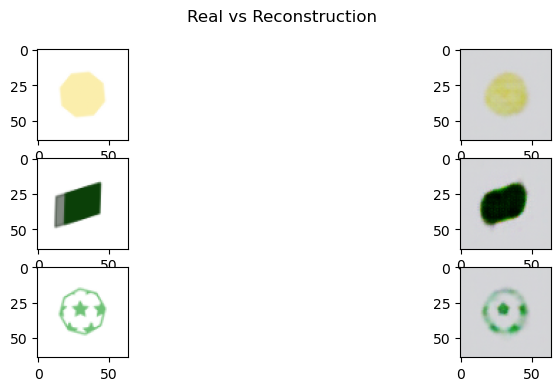

Epoch 5 | train loss 3345.43 | valid loss 3103.78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:56<00:00,  5.02it/s]
Epoch 6:   0%|▋                                                                                                                                                                                         | 1/282 [00:00<00:55,  5.03it/s]

tensor(3.1431, grad_fn=<MseLossBackward0>)
tensor(3.2395, grad_fn=<MseLossBackward0>)


Epoch 6:   1%|█▉                                                                                                                                                                                        | 3/282 [00:00<00:50,  5.54it/s]

tensor(3.7852, grad_fn=<MseLossBackward0>)
tensor(2.6199, grad_fn=<MseLossBackward0>)


Epoch 6:   2%|███▎                                                                                                                                                                                      | 5/282 [00:00<00:48,  5.70it/s]

tensor(2.4756, grad_fn=<MseLossBackward0>)
tensor(4.1056, grad_fn=<MseLossBackward0>)


Epoch 6:   2%|████▌                                                                                                                                                                                     | 7/282 [00:01<00:49,  5.56it/s]

tensor(2.8822, grad_fn=<MseLossBackward0>)
tensor(3.5804, grad_fn=<MseLossBackward0>)


Epoch 6:   3%|█████▉                                                                                                                                                                                    | 9/282 [00:01<00:46,  5.83it/s]

tensor(3.3679, grad_fn=<MseLossBackward0>)
tensor(3.4837, grad_fn=<MseLossBackward0>)


Epoch 6:   4%|███████▏                                                                                                                                                                                 | 11/282 [00:01<00:46,  5.79it/s]

tensor(3.0716, grad_fn=<MseLossBackward0>)
tensor(2.4772, grad_fn=<MseLossBackward0>)


Epoch 6:   5%|████████▌                                                                                                                                                                                | 13/282 [00:02<00:46,  5.76it/s]

tensor(2.7633, grad_fn=<MseLossBackward0>)
tensor(3.2714, grad_fn=<MseLossBackward0>)


Epoch 6:   5%|█████████▊                                                                                                                                                                               | 15/282 [00:02<00:46,  5.74it/s]

tensor(3.1958, grad_fn=<MseLossBackward0>)
tensor(1.9961, grad_fn=<MseLossBackward0>)


Epoch 6:   6%|███████████▏                                                                                                                                                                             | 17/282 [00:02<00:47,  5.59it/s]

tensor(2.9073, grad_fn=<MseLossBackward0>)
tensor(2.8271, grad_fn=<MseLossBackward0>)


Epoch 6:   7%|████████████▍                                                                                                                                                                            | 19/282 [00:03<00:46,  5.67it/s]

tensor(3.4604, grad_fn=<MseLossBackward0>)
tensor(2.6511, grad_fn=<MseLossBackward0>)


Epoch 6:   7%|█████████████▊                                                                                                                                                                           | 21/282 [00:03<00:46,  5.66it/s]

tensor(3.5020, grad_fn=<MseLossBackward0>)
tensor(2.4260, grad_fn=<MseLossBackward0>)


Epoch 6:   8%|███████████████                                                                                                                                                                          | 23/282 [00:04<00:46,  5.55it/s]

tensor(2.9578, grad_fn=<MseLossBackward0>)
tensor(2.4528, grad_fn=<MseLossBackward0>)


Epoch 6:   9%|████████████████▍                                                                                                                                                                        | 25/282 [00:04<00:48,  5.35it/s]

tensor(4.1098, grad_fn=<MseLossBackward0>)


Epoch 6:   9%|█████████████████                                                                                                                                                                        | 26/282 [00:04<00:50,  5.12it/s]

tensor(2.6341, grad_fn=<MseLossBackward0>)


Epoch 6:  10%|█████████████████▋                                                                                                                                                                       | 27/282 [00:04<00:50,  5.03it/s]

tensor(3.0600, grad_fn=<MseLossBackward0>)
tensor(2.7961, grad_fn=<MseLossBackward0>)


Epoch 6:  10%|███████████████████                                                                                                                                                                      | 29/282 [00:05<00:47,  5.37it/s]

tensor(3.4767, grad_fn=<MseLossBackward0>)
tensor(2.8506, grad_fn=<MseLossBackward0>)


Epoch 6:  11%|████████████████████▎                                                                                                                                                                    | 31/282 [00:05<00:46,  5.35it/s]

tensor(2.8115, grad_fn=<MseLossBackward0>)
tensor(2.8066, grad_fn=<MseLossBackward0>)


Epoch 6:  12%|█████████████████████▋                                                                                                                                                                   | 33/282 [00:05<00:45,  5.42it/s]

tensor(3.6934, grad_fn=<MseLossBackward0>)
tensor(2.3865, grad_fn=<MseLossBackward0>)


Epoch 6:  12%|██████████████████████▉                                                                                                                                                                  | 35/282 [00:06<00:45,  5.44it/s]

tensor(2.8153, grad_fn=<MseLossBackward0>)
tensor(3.2576, grad_fn=<MseLossBackward0>)


Epoch 6:  13%|████████████████████████▎                                                                                                                                                                | 37/282 [00:06<00:44,  5.54it/s]

tensor(2.7316, grad_fn=<MseLossBackward0>)


Epoch 6:  13%|████████████████████████▉                                                                                                                                                                | 38/282 [00:06<00:48,  5.07it/s]

tensor(2.4728, grad_fn=<MseLossBackward0>)


Epoch 6:  14%|█████████████████████████▌                                                                                                                                                               | 39/282 [00:07<00:46,  5.21it/s]

tensor(2.3921, grad_fn=<MseLossBackward0>)
tensor(2.1493, grad_fn=<MseLossBackward0>)


Epoch 6:  15%|██████████████████████████▉                                                                                                                                                              | 41/282 [00:07<00:45,  5.33it/s]

tensor(3.0090, grad_fn=<MseLossBackward0>)
tensor(2.7054, grad_fn=<MseLossBackward0>)


Epoch 6:  15%|████████████████████████████▏                                                                                                                                                            | 43/282 [00:07<00:43,  5.44it/s]

tensor(2.7438, grad_fn=<MseLossBackward0>)
tensor(3.1763, grad_fn=<MseLossBackward0>)


Epoch 6:  16%|█████████████████████████████▌                                                                                                                                                           | 45/282 [00:08<00:41,  5.74it/s]

tensor(2.9926, grad_fn=<MseLossBackward0>)
tensor(2.8789, grad_fn=<MseLossBackward0>)


Epoch 6:  17%|██████████████████████████████▊                                                                                                                                                          | 47/282 [00:08<00:42,  5.54it/s]

tensor(2.9087, grad_fn=<MseLossBackward0>)
tensor(3.5162, grad_fn=<MseLossBackward0>)


Epoch 6:  17%|████████████████████████████████▏                                                                                                                                                        | 49/282 [00:08<00:41,  5.61it/s]

tensor(3.2954, grad_fn=<MseLossBackward0>)
tensor(3.1638, grad_fn=<MseLossBackward0>)


Epoch 6:  18%|█████████████████████████████████▍                                                                                                                                                       | 51/282 [00:09<00:42,  5.46it/s]

tensor(3.9938, grad_fn=<MseLossBackward0>)
tensor(3.1942, grad_fn=<MseLossBackward0>)


Epoch 6:  19%|██████████████████████████████████▊                                                                                                                                                      | 53/282 [00:09<00:41,  5.49it/s]

tensor(2.9232, grad_fn=<MseLossBackward0>)
tensor(3.1256, grad_fn=<MseLossBackward0>)


Epoch 6:  20%|████████████████████████████████████                                                                                                                                                     | 55/282 [00:09<00:41,  5.44it/s]

tensor(3.6713, grad_fn=<MseLossBackward0>)
tensor(2.9889, grad_fn=<MseLossBackward0>)


Epoch 6:  20%|█████████████████████████████████████▍                                                                                                                                                   | 57/282 [00:10<00:41,  5.38it/s]

tensor(2.2380, grad_fn=<MseLossBackward0>)
tensor(4.3557, grad_fn=<MseLossBackward0>)


Epoch 6:  21%|██████████████████████████████████████▋                                                                                                                                                  | 59/282 [00:10<00:40,  5.44it/s]

tensor(1.7877, grad_fn=<MseLossBackward0>)
tensor(3.7941, grad_fn=<MseLossBackward0>)


Epoch 6:  22%|████████████████████████████████████████                                                                                                                                                 | 61/282 [00:11<00:40,  5.48it/s]

tensor(4.0098, grad_fn=<MseLossBackward0>)
tensor(2.7800, grad_fn=<MseLossBackward0>)


Epoch 6:  22%|█████████████████████████████████████████▎                                                                                                                                               | 63/282 [00:11<00:40,  5.47it/s]

tensor(4.0442, grad_fn=<MseLossBackward0>)
tensor(2.7155, grad_fn=<MseLossBackward0>)


Epoch 6:  23%|██████████████████████████████████████████▋                                                                                                                                              | 65/282 [00:11<00:39,  5.51it/s]

tensor(3.8615, grad_fn=<MseLossBackward0>)
tensor(2.7748, grad_fn=<MseLossBackward0>)


Epoch 6:  24%|███████████████████████████████████████████▉                                                                                                                                             | 67/282 [00:12<00:37,  5.69it/s]

tensor(3.2374, grad_fn=<MseLossBackward0>)
tensor(2.6877, grad_fn=<MseLossBackward0>)


Epoch 6:  24%|█████████████████████████████████████████████▎                                                                                                                                           | 69/282 [00:12<00:37,  5.62it/s]

tensor(3.2788, grad_fn=<MseLossBackward0>)
tensor(2.9956, grad_fn=<MseLossBackward0>)


Epoch 6:  25%|██████████████████████████████████████████████▌                                                                                                                                          | 71/282 [00:12<00:38,  5.52it/s]

tensor(4.3519, grad_fn=<MseLossBackward0>)
tensor(2.5883, grad_fn=<MseLossBackward0>)


Epoch 6:  26%|███████████████████████████████████████████████▉                                                                                                                                         | 73/282 [00:13<00:38,  5.46it/s]

tensor(2.6866, grad_fn=<MseLossBackward0>)
tensor(3.2290, grad_fn=<MseLossBackward0>)


Epoch 6:  27%|█████████████████████████████████████████████████▏                                                                                                                                       | 75/282 [00:13<00:37,  5.53it/s]

tensor(2.4848, grad_fn=<MseLossBackward0>)
tensor(1.7597, grad_fn=<MseLossBackward0>)


Epoch 6:  27%|██████████████████████████████████████████████████▌                                                                                                                                      | 77/282 [00:13<00:37,  5.50it/s]

tensor(2.6511, grad_fn=<MseLossBackward0>)
tensor(2.9166, grad_fn=<MseLossBackward0>)


Epoch 6:  28%|███████████████████████████████████████████████████▊                                                                                                                                     | 79/282 [00:14<00:36,  5.52it/s]

tensor(2.6789, grad_fn=<MseLossBackward0>)
tensor(2.1534, grad_fn=<MseLossBackward0>)


Epoch 6:  29%|█████████████████████████████████████████████████████▏                                                                                                                                   | 81/282 [00:14<00:36,  5.57it/s]

tensor(3.4128, grad_fn=<MseLossBackward0>)
tensor(2.5708, grad_fn=<MseLossBackward0>)


Epoch 6:  29%|██████████████████████████████████████████████████████▍                                                                                                                                  | 83/282 [00:15<00:35,  5.61it/s]

tensor(3.4169, grad_fn=<MseLossBackward0>)
tensor(2.3733, grad_fn=<MseLossBackward0>)


Epoch 6:  30%|███████████████████████████████████████████████████████▊                                                                                                                                 | 85/282 [00:15<00:35,  5.48it/s]

tensor(3.5691, grad_fn=<MseLossBackward0>)
tensor(3.3860, grad_fn=<MseLossBackward0>)


Epoch 6:  31%|█████████████████████████████████████████████████████████                                                                                                                                | 87/282 [00:15<00:35,  5.54it/s]

tensor(2.2815, grad_fn=<MseLossBackward0>)
tensor(2.8327, grad_fn=<MseLossBackward0>)


Epoch 6:  32%|██████████████████████████████████████████████████████████▍                                                                                                                              | 89/282 [00:16<00:34,  5.56it/s]

tensor(2.8248, grad_fn=<MseLossBackward0>)
tensor(2.0895, grad_fn=<MseLossBackward0>)


Epoch 6:  32%|███████████████████████████████████████████████████████████▋                                                                                                                             | 91/282 [00:16<00:33,  5.62it/s]

tensor(2.7275, grad_fn=<MseLossBackward0>)
tensor(3.5911, grad_fn=<MseLossBackward0>)


Epoch 6:  33%|█████████████████████████████████████████████████████████████                                                                                                                            | 93/282 [00:16<00:33,  5.63it/s]

tensor(3.0128, grad_fn=<MseLossBackward0>)
tensor(3.3350, grad_fn=<MseLossBackward0>)


Epoch 6:  34%|██████████████████████████████████████████████████████████████▎                                                                                                                          | 95/282 [00:17<00:32,  5.69it/s]

tensor(2.7277, grad_fn=<MseLossBackward0>)
tensor(2.5645, grad_fn=<MseLossBackward0>)


Epoch 6:  34%|███████████████████████████████████████████████████████████████▋                                                                                                                         | 97/282 [00:17<00:32,  5.74it/s]

tensor(2.1841, grad_fn=<MseLossBackward0>)
tensor(2.9405, grad_fn=<MseLossBackward0>)


Epoch 6:  35%|████████████████████████████████████████████████████████████████▉                                                                                                                        | 99/282 [00:17<00:32,  5.61it/s]

tensor(2.9621, grad_fn=<MseLossBackward0>)
tensor(2.9120, grad_fn=<MseLossBackward0>)


Epoch 6:  36%|█████████████████████████████████████████████████████████████████▉                                                                                                                      | 101/282 [00:18<00:31,  5.70it/s]

tensor(3.0967, grad_fn=<MseLossBackward0>)
tensor(2.3791, grad_fn=<MseLossBackward0>)


Epoch 6:  37%|███████████████████████████████████████████████████████████████████▏                                                                                                                    | 103/282 [00:18<00:30,  5.78it/s]

tensor(2.5556, grad_fn=<MseLossBackward0>)


Epoch 6:  37%|███████████████████████████████████████████████████████████████████▊                                                                                                                    | 104/282 [00:18<00:37,  4.69it/s]

tensor(2.1750, grad_fn=<MseLossBackward0>)


Epoch 6:  37%|████████████████████████████████████████████████████████████████████▌                                                                                                                   | 105/282 [00:19<00:35,  5.02it/s]

tensor(2.1976, grad_fn=<MseLossBackward0>)
tensor(3.5699, grad_fn=<MseLossBackward0>)


Epoch 6:  38%|█████████████████████████████████████████████████████████████████████▊                                                                                                                  | 107/282 [00:19<00:33,  5.25it/s]

tensor(5.0222, grad_fn=<MseLossBackward0>)
tensor(1.7796, grad_fn=<MseLossBackward0>)


Epoch 6:  39%|███████████████████████████████████████████████████████████████████████                                                                                                                 | 109/282 [00:19<00:32,  5.39it/s]

tensor(4.1182, grad_fn=<MseLossBackward0>)
tensor(3.0823, grad_fn=<MseLossBackward0>)


Epoch 6:  39%|████████████████████████████████████████████████████████████████████████▍                                                                                                               | 111/282 [00:20<00:30,  5.57it/s]

tensor(3.3111, grad_fn=<MseLossBackward0>)
tensor(3.5034, grad_fn=<MseLossBackward0>)


Epoch 6:  40%|█████████████████████████████████████████████████████████████████████████▋                                                                                                              | 113/282 [00:20<00:30,  5.54it/s]

tensor(2.5505, grad_fn=<MseLossBackward0>)
tensor(3.1568, grad_fn=<MseLossBackward0>)


Epoch 6:  41%|███████████████████████████████████████████████████████████████████████████                                                                                                             | 115/282 [00:20<00:29,  5.67it/s]

tensor(1.8751, grad_fn=<MseLossBackward0>)
tensor(4.7500, grad_fn=<MseLossBackward0>)


Epoch 6:  41%|████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 117/282 [00:21<00:29,  5.62it/s]

tensor(3.3144, grad_fn=<MseLossBackward0>)
tensor(2.2253, grad_fn=<MseLossBackward0>)


Epoch 6:  42%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 119/282 [00:21<00:28,  5.67it/s]

tensor(3.5896, grad_fn=<MseLossBackward0>)
tensor(2.0092, grad_fn=<MseLossBackward0>)


Epoch 6:  43%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 121/282 [00:21<00:28,  5.64it/s]

tensor(2.7286, grad_fn=<MseLossBackward0>)
tensor(2.8642, grad_fn=<MseLossBackward0>)


Epoch 6:  44%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 123/282 [00:22<00:28,  5.50it/s]

tensor(2.8383, grad_fn=<MseLossBackward0>)
tensor(3.6570, grad_fn=<MseLossBackward0>)


Epoch 6:  44%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 125/282 [00:22<00:28,  5.45it/s]

tensor(2.9675, grad_fn=<MseLossBackward0>)
tensor(2.6708, grad_fn=<MseLossBackward0>)


Epoch 6:  45%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 127/282 [00:23<00:27,  5.56it/s]

tensor(2.2473, grad_fn=<MseLossBackward0>)
tensor(3.2835, grad_fn=<MseLossBackward0>)


Epoch 6:  46%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 129/282 [00:23<00:26,  5.77it/s]

tensor(3.3765, grad_fn=<MseLossBackward0>)
tensor(3.4127, grad_fn=<MseLossBackward0>)


Epoch 6:  46%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 131/282 [00:23<00:26,  5.73it/s]

tensor(3.0834, grad_fn=<MseLossBackward0>)
tensor(2.8707, grad_fn=<MseLossBackward0>)


Epoch 6:  47%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 133/282 [00:24<00:26,  5.67it/s]

tensor(2.3580, grad_fn=<MseLossBackward0>)
tensor(2.4087, grad_fn=<MseLossBackward0>)


Epoch 6:  48%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 135/282 [00:24<00:25,  5.74it/s]

tensor(2.3597, grad_fn=<MseLossBackward0>)
tensor(2.9635, grad_fn=<MseLossBackward0>)


Epoch 6:  49%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 137/282 [00:24<00:25,  5.72it/s]

tensor(3.7223, grad_fn=<MseLossBackward0>)
tensor(3.1524, grad_fn=<MseLossBackward0>)


Epoch 6:  49%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 139/282 [00:25<00:24,  5.76it/s]

tensor(3.2435, grad_fn=<MseLossBackward0>)
tensor(4.6006, grad_fn=<MseLossBackward0>)


Epoch 6:  50%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 141/282 [00:25<00:24,  5.65it/s]

tensor(2.4841, grad_fn=<MseLossBackward0>)
tensor(3.1897, grad_fn=<MseLossBackward0>)


Epoch 6:  51%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 143/282 [00:25<00:24,  5.63it/s]

tensor(2.5565, grad_fn=<MseLossBackward0>)
tensor(2.6631, grad_fn=<MseLossBackward0>)


Epoch 6:  51%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 145/282 [00:26<00:23,  5.75it/s]

tensor(2.3761, grad_fn=<MseLossBackward0>)
tensor(3.4954, grad_fn=<MseLossBackward0>)


Epoch 6:  52%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 147/282 [00:26<00:23,  5.77it/s]

tensor(2.6359, grad_fn=<MseLossBackward0>)
tensor(2.9652, grad_fn=<MseLossBackward0>)


Epoch 6:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 149/282 [00:26<00:23,  5.58it/s]

tensor(2.1901, grad_fn=<MseLossBackward0>)
tensor(2.6185, grad_fn=<MseLossBackward0>)


Epoch 6:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 151/282 [00:27<00:23,  5.63it/s]

tensor(2.5706, grad_fn=<MseLossBackward0>)
tensor(3.4462, grad_fn=<MseLossBackward0>)


Epoch 6:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 153/282 [00:27<00:22,  5.72it/s]

tensor(2.8184, grad_fn=<MseLossBackward0>)
tensor(3.1541, grad_fn=<MseLossBackward0>)


Epoch 6:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 155/282 [00:27<00:22,  5.61it/s]

tensor(2.9509, grad_fn=<MseLossBackward0>)
tensor(2.7389, grad_fn=<MseLossBackward0>)


Epoch 6:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 157/282 [00:28<00:22,  5.68it/s]

tensor(3.3196, grad_fn=<MseLossBackward0>)
tensor(4.2024, grad_fn=<MseLossBackward0>)


Epoch 6:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 159/282 [00:28<00:21,  5.61it/s]

tensor(2.5716, grad_fn=<MseLossBackward0>)
tensor(2.7322, grad_fn=<MseLossBackward0>)


Epoch 6:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 161/282 [00:28<00:21,  5.63it/s]

tensor(3.7734, grad_fn=<MseLossBackward0>)
tensor(2.4134, grad_fn=<MseLossBackward0>)


Epoch 6:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 163/282 [00:29<00:21,  5.46it/s]

tensor(3.0300, grad_fn=<MseLossBackward0>)
tensor(3.1295, grad_fn=<MseLossBackward0>)


Epoch 6:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 165/282 [00:29<00:21,  5.49it/s]

tensor(4.2180, grad_fn=<MseLossBackward0>)
tensor(2.1694, grad_fn=<MseLossBackward0>)


Epoch 6:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 167/282 [00:30<00:20,  5.53it/s]

tensor(3.6337, grad_fn=<MseLossBackward0>)
tensor(3.8838, grad_fn=<MseLossBackward0>)


Epoch 6:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 169/282 [00:30<00:20,  5.51it/s]

tensor(3.1442, grad_fn=<MseLossBackward0>)
tensor(2.8545, grad_fn=<MseLossBackward0>)


Epoch 6:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 171/282 [00:30<00:19,  5.65it/s]

tensor(4.7188, grad_fn=<MseLossBackward0>)
tensor(4.9753, grad_fn=<MseLossBackward0>)


Epoch 6:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 173/282 [00:31<00:19,  5.61it/s]

tensor(2.9373, grad_fn=<MseLossBackward0>)
tensor(3.0629, grad_fn=<MseLossBackward0>)


Epoch 6:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 175/282 [00:31<00:18,  5.67it/s]

tensor(3.2412, grad_fn=<MseLossBackward0>)
tensor(2.9876, grad_fn=<MseLossBackward0>)


Epoch 6:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 177/282 [00:31<00:18,  5.59it/s]

tensor(3.2380, grad_fn=<MseLossBackward0>)
tensor(2.8273, grad_fn=<MseLossBackward0>)


Epoch 6:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 179/282 [00:32<00:18,  5.63it/s]

tensor(3.9593, grad_fn=<MseLossBackward0>)
tensor(2.6353, grad_fn=<MseLossBackward0>)


Epoch 6:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 181/282 [00:32<00:17,  5.68it/s]

tensor(3.0024, grad_fn=<MseLossBackward0>)
tensor(2.5264, grad_fn=<MseLossBackward0>)


Epoch 6:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 183/282 [00:32<00:17,  5.67it/s]

tensor(3.9311, grad_fn=<MseLossBackward0>)
tensor(2.8748, grad_fn=<MseLossBackward0>)


Epoch 6:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 185/282 [00:33<00:17,  5.69it/s]

tensor(2.5302, grad_fn=<MseLossBackward0>)
tensor(2.1915, grad_fn=<MseLossBackward0>)


Epoch 6:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 187/282 [00:33<00:16,  5.69it/s]

tensor(2.9923, grad_fn=<MseLossBackward0>)
tensor(2.8110, grad_fn=<MseLossBackward0>)


Epoch 6:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 189/282 [00:33<00:16,  5.61it/s]

tensor(3.0626, grad_fn=<MseLossBackward0>)
tensor(2.2445, grad_fn=<MseLossBackward0>)


Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 191/282 [00:34<00:16,  5.56it/s]

tensor(3.2285, grad_fn=<MseLossBackward0>)
tensor(2.8495, grad_fn=<MseLossBackward0>)


Epoch 6:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 193/282 [00:34<00:15,  5.64it/s]

tensor(2.6516, grad_fn=<MseLossBackward0>)
tensor(3.9721, grad_fn=<MseLossBackward0>)


Epoch 6:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 195/282 [00:35<00:15,  5.50it/s]

tensor(3.2650, grad_fn=<MseLossBackward0>)
tensor(2.7069, grad_fn=<MseLossBackward0>)


Epoch 6:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 197/282 [00:35<00:15,  5.54it/s]

tensor(2.1149, grad_fn=<MseLossBackward0>)
tensor(2.7833, grad_fn=<MseLossBackward0>)


Epoch 6:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 199/282 [00:35<00:14,  5.66it/s]

tensor(2.2789, grad_fn=<MseLossBackward0>)
tensor(2.2343, grad_fn=<MseLossBackward0>)


Epoch 6:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 201/282 [00:36<00:14,  5.71it/s]

tensor(3.3956, grad_fn=<MseLossBackward0>)
tensor(2.6066, grad_fn=<MseLossBackward0>)


Epoch 6:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 203/282 [00:36<00:14,  5.52it/s]

tensor(2.0749, grad_fn=<MseLossBackward0>)


Epoch 6:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 204/282 [00:36<00:14,  5.37it/s]

tensor(3.4360, grad_fn=<MseLossBackward0>)
tensor(2.4800, grad_fn=<MseLossBackward0>)


Epoch 6:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 206/282 [00:37<00:13,  5.54it/s]

tensor(2.0161, grad_fn=<MseLossBackward0>)
tensor(3.4284, grad_fn=<MseLossBackward0>)


Epoch 6:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 208/282 [00:37<00:13,  5.51it/s]

tensor(2.6244, grad_fn=<MseLossBackward0>)
tensor(2.5255, grad_fn=<MseLossBackward0>)


Epoch 6:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 210/282 [00:37<00:12,  5.56it/s]

tensor(2.2991, grad_fn=<MseLossBackward0>)
tensor(4.0060, grad_fn=<MseLossBackward0>)


Epoch 6:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 212/282 [00:38<00:12,  5.61it/s]

tensor(2.2337, grad_fn=<MseLossBackward0>)
tensor(3.2511, grad_fn=<MseLossBackward0>)


Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 214/282 [00:38<00:12,  5.50it/s]

tensor(2.7287, grad_fn=<MseLossBackward0>)
tensor(3.8484, grad_fn=<MseLossBackward0>)


Epoch 6:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 216/282 [00:38<00:11,  5.55it/s]

tensor(3.3775, grad_fn=<MseLossBackward0>)
tensor(2.9647, grad_fn=<MseLossBackward0>)


Epoch 6:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 218/282 [00:39<00:11,  5.44it/s]

tensor(2.9126, grad_fn=<MseLossBackward0>)
tensor(2.5360, grad_fn=<MseLossBackward0>)


Epoch 6:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 220/282 [00:39<00:11,  5.44it/s]

tensor(2.5298, grad_fn=<MseLossBackward0>)
tensor(3.1099, grad_fn=<MseLossBackward0>)


Epoch 6:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 221/282 [00:39<00:10,  5.55it/s]


KeyboardInterrupt: 

In [16]:
from torch.utils.data import DataLoader

net = SupervisedBVAE(z_dim)
net = net.to(device)
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)

train_dataloader = DataLoader(DatasetWrapper(train, train_meta), batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(DatasetWrapper(valid, valid_meta), batch_size=batch_size, shuffle=False)

num_batches = len(train_dataloader)
num_valid_batches = len(valid_dataloader)


train_losses, valid_losses = [], []

update_idxs = set([i * (num_batches // updates_per_epoch)
    for i in range(1, updates_per_epoch)] + [num_batches])

best_valid = 1e9
for epoch in range(1, 1+num_epochs):
    total_loss = 0.0 

    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch}", leave=True, total=num_batches)
    optimizer.zero_grad()
    for idx, batch in enumerate(pbar, start=1):
        x, latent_supervision = batch
        x = x.to(device) # how inefficient is it to stream batches to the device like this? I guess it saves GPU memory

        recon, mu, var, _, yhat = net(x)
        
        loss = supervised_vae_loss(x, yhat, latent_supervision, mu, var, recon, beta)

        total_loss += loss.item() / gradient_accumulation_steps
        loss = loss / gradient_accumulation_steps
        loss.backward()
        
        if (idx % gradient_accumulation_steps == 0) or (idx == num_batches):
            optimizer.step()
            optimizer.zero_grad()

        if idx in update_idxs:
            avg_valid_loss = 0.0
            
            displays = []
            net.eval()
            with torch.no_grad():
                for batch in valid_dataloader:
                    x, latent_supervision = batch
                    recon, mu, var, z, yhat = net(x)
                    loss = supervised_vae_loss(x, yhat, latent_supervision, mu, var, recon, beta)
                    avg_valid_loss += loss.item() / num_valid_batches
                    if not displays:
                        net.random_z = tuple(z[0].detach().cpu().numpy())
                        displays = [
                            (x[0].permute(1, 2, 0).cpu().numpy(), recon[0].permute(1, 2, 0).cpu().numpy()), 
                            (x[1].permute(1, 2, 0).cpu().numpy(), recon[1].permute(1, 2, 0).cpu().numpy()),
                            (x[2].permute(1, 2, 0).cpu().numpy(), recon[2].permute(1, 2, 0).cpu().numpy())
                        ]
                
                if avg_valid_loss < best_valid:
                    torch.save(net, f'models/{beta}-bvae-{z_dim}dim')
                    best_valid = avg_valid_loss
                    
                valid_losses.append(avg_valid_loss)
                
                if idx == num_batches:
                    fig, axes = plt.subplots(3, 2)
                    fig.suptitle('Real vs Reconstruction')
                    fig.set_size_inches(10, 4)
                    for (ax1, ax2), (im1, im2) in zip(axes, displays):
                        ax1.imshow(im1)
                        ax2.imshow(im2)
                    plt.show()
            net.train()


            pbar.set_description(f"Epoch {epoch} | train loss {total_loss / idx:.2f}" + \
                                f" | valid loss {avg_valid_loss:.2f}")
            train_losses.append(total_loss / idx) 

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.legend()
plt.show()